# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import spearmanr, randint
from sklearn.model_selection import (
    train_test_split, cross_val_score, cross_val_predict, 
    GridSearchCV, RandomizedSearchCV, learning_curve
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE, mutual_info_regression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, 
    matthews_corrcoef
)
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

from hyperopt import fmin, tpe, hp, Trials
from hyperopt.pyll.base import scope

from explainerdashboard import ClassifierExplainer, ExplainerDashboard, ExplainerHub

# Set global random seed
random_seed = 42

# Display all columns and rows in pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


# Model on 1st visit

In [2]:
# Load data visit 1
test_df_model_1_visit = pd.read_csv("../data/test_df_imputed_1stvisit.csv")
train_df_model_1_visit = pd.read_csv("../data/train_df_imputed_1stvisit.csv")

In [4]:
# Hospital suggested to remove these features
features_to_remove = ["NPI_TOT", "CDR1", "CDR2", "CDR3", "CDR4", "CDR5", "CDR6", "IADL1", "IADL2", 
    "IADL3", "IADL4", "IADL5", "IADL6", "IADL7", "IADL8", "HACH_TOT", "UPDRS1", "UPDRS2", "UPDRS3a", "UPDRS3b", "UPDRS3c", 
    "UPDRS3d", "UPDRS3e", "UPDRS4a", "UPDRS4b", "UPDRS5a", "UPDRS5b", "UPDRS5c", "UPDRS5d", "UPDRS5e", 
    "UPDRS6a", "UPDRS6b", "UPDRS7a", "UPDRS7b", "UPDRS8a", "UPDRS8b", "UPDRS9a", "UPDRS9b", "UPDRS10", 
    "UPDRS11", "UPDRS12", "UPDRS13", "UPDRS14",'CSF_AB4', 'CSF_T4', 'CSF_PHT4', 'AMYLOID_NOMINAL', 'TAU_NOMINAL', 'PHTAU_NOMINAL',]

train_df_model_1_visit = train_df_model_1_visit.drop(columns=features_to_remove)
test_df_model_1_visit = test_df_model_1_visit.drop(columns=features_to_remove)

In [5]:
# Necessary for feature refinement step
df_model_1_visit = pd.concat([train_df_model_1_visit, test_df_model_1_visit], axis=0)

In [8]:
# Fix data types
categorical_columns = ["ΜaritalC", "Living_Arrangement", "WorkStat"]

int_columns = ["SEX", "EDU", "AgeC", "MH1", "MH2", "MH3", "MH4", "MH5", "MH6", "MH7", 
    "MH8", "MH9", "MH10", "MH11", "MH12", "MH13", "MH14", "MH15", "MH16", "MH17", "MH18", "MH19", 
    "MH20", "MH21", "MH22", "SMOKING", "ALCOHOL", "MED1", "MED2", "MED3", "MED4", "MED5", "MED6", 
    "MED7", "MED8", "MED9", "MED10", "MED11", "MED12", "MED13", "MED14", "MED15", "MED16", "MED17", 
    "MED18", "MED19", "MED20", "MED21", "MED22", "MED23", "MED24", "MED25", "MED26", "FH5", "FH6", "FH7", "FH8", "FH9", "FH10", "FH11", "FH12", "FH13", "FH14", "FH15", 
    "FH16", "NPI1", "NPI2", "NPI3", "NPI4", "NPI5", "NPI6", "NPI7", "NPI8", "NPI9", "NPI10", "NPI11", 
    "NPI12", "IADL_TOT", "HACH1", "HACH2", "HACH3", "HACH4", 
    "HACH5", "HACH6", "HACH7", "HACH8", "UPDRS_TOT", "DIAGNOSIS",
    "HADS_A1", "HADS_D1", "HADS_A2", "HADS_D2", "HADS_A3", "HADS_D3", "HADS_A4", "HADS_D4", "HADS_A5", "HADS_D5", "HADS_A6", "HADS_D6", "HADS_A7", "HADS_D7",
    'H1', 'H2a', 'H2b', 'H3', 'H4', 'H5',
    'H6', 'H7', 'H8', 'H9', 'H10', 'H11', 'H12',
    "E1a", "E2a", "E3a", "E4a", "E5a", "E6a", "E7a", "E8a", "E9a", "E10a",
    "E11a", "E12a", "E13a", "E14a", "E15a", "E16a", "E17a", "E18a", "E19a",
    "E20a", "E21a", "E22a", "E23a",
    "SCC1", "SCC2", "SCC3", "SCC4", "SCC5", "SCC6", "SCC7", "SCC8", "SCC9",
    "SCC10", "SCC11", "SCC12", "SCC13", "SCC14", "SCC15", "ATN_classification"
    ]

df_model_1_visit[categorical_columns] = df_model_1_visit[categorical_columns].astype('category')
test_df_model_1_visit[categorical_columns] = test_df_model_1_visit[categorical_columns].astype('category')
train_df_model_1_visit[categorical_columns] = train_df_model_1_visit[categorical_columns].astype('category')
df_model_1_visit[categorical_columns] = df_model_1_visit[categorical_columns].apply(lambda col: col.cat.codes)
test_df_model_1_visit[categorical_columns] = test_df_model_1_visit[categorical_columns].apply(lambda col: col.cat.codes)
train_df_model_1_visit[categorical_columns] = train_df_model_1_visit[categorical_columns].apply(lambda col: col.cat.codes)

df_model_1_visit[int_columns] = df_model_1_visit[int_columns].astype(int)
test_df_model_1_visit[int_columns] = test_df_model_1_visit[int_columns].astype(int)
train_df_model_1_visit[int_columns] = train_df_model_1_visit[int_columns].astype(int)

In [11]:
# Remove features with a constant value
constant_columns_model_1_visit = [col for col in df_model_1_visit.columns if df_model_1_visit[col].nunique() == 1]

test_df_model_1_visit = test_df_model_1_visit.drop(labels=constant_columns_model_1_visit, axis=1)
train_df_model_1_visit = train_df_model_1_visit.drop(labels=constant_columns_model_1_visit, axis=1)
df_model_1_visit = df_model_1_visit.drop(labels=constant_columns_model_1_visit, axis=1)

In [12]:
X_model_1_visit = df_model_1_visit.values
feature_names_model_1_visit = df_model_1_visit.columns

# Calculate the Spearman correlation matrix
spearman_corr_matrix_model_1_visit = np.empty((X_model_1_visit.shape[1], X_model_1_visit.shape[1]))
for i in range(X_model_1_visit.shape[1]):
    for j in range(X_model_1_visit.shape[1]):
        spearman_corr_matrix_model_1_visit[i, j], _ = spearmanr(X_model_1_visit[:, i], X_model_1_visit[:, j])

# Print the Spearman correlation matrix
print("Spearman correlation matrix:")
print(spearman_corr_matrix_model_1_visit)

# Calculate the mutual information
mutual_info_matrix_model_1_visit = np.empty((X_model_1_visit.shape[1], X_model_1_visit.shape[1]))
for i in range(X_model_1_visit.shape[1]):
    mutual_info_matrix_model_1_visit[i] = mutual_info_regression(X_model_1_visit, X_model_1_visit[:, i], random_state=29)

# Print the mutual information matrix
print("\nMutual information matrix:")
print(mutual_info_matrix_model_1_visit)

# Compute the average absolute value of the correlations
avg_spearman_corr_model_1_visit = np.mean(np.abs(spearman_corr_matrix_model_1_visit), axis=0)
avg_mutual_info_model_1_visit = np.mean(np.abs(mutual_info_matrix_model_1_visit), axis=0)

# Print average Spearman correlation and mutual information
print("\nAverage Spearman correlation:")
print(avg_spearman_corr_model_1_visit)
print("\nAverage mutual information:")
print(avg_mutual_info_model_1_visit)

# Combine the two averaged correlations
combined_corr_model_1_visit = avg_spearman_corr_model_1_visit + avg_mutual_info_model_1_visit

# Print combined correlation
print("\nCombined correlation (Spearman + Mutual Info):")
print(combined_corr_model_1_visit)

# Scale the combined values between 0 and 1
scaler_model_1_visit = MinMaxScaler()
scaled_combined_corr_model_1_visit = scaler_model_1_visit.fit_transform(combined_corr_model_1_visit.reshape(-1, 1)).flatten()

# Print scaled combined correlation
print("\nScaled combined correlation:")
print(scaled_combined_corr_model_1_visit)

# Sum the scaled values for each feature
final_values_model_1_visit = scaled_combined_corr_model_1_visit + scaled_combined_corr_model_1_visit

# Print final values for each feature
print("\nFinal values (scaled combined correlation + itself):")
print(final_values_model_1_visit)

# Create the resulting DataFrame
result_df_model_1_visit = pd.DataFrame({
    'feature_name': feature_names_model_1_visit,
    'value': final_values_model_1_visit
})

# Sort the DataFrame by the 'value' column
sorted_df_model_1_visit = result_df_model_1_visit.sort_values('value', ascending=False)

# Print the sorted DataFrame
print("\nSorted DataFrame:")
print(sorted_df_model_1_visit)

# Compute the cumulative sum of the 'value' column
sorted_df_model_1_visit['cumulative_sum'] = sorted_df_model_1_visit['value'].cumsum()

# Print the DataFrame with cumulative sum
print("\nDataFrame with cumulative sum:")
print(sorted_df_model_1_visit)

# Check if any rows meet the 95% cumulative sum threshold
filtered_df_model_1_visit = sorted_df_model_1_visit[sorted_df_model_1_visit['cumulative_sum'] > 0.95 * sorted_df_model_1_visit['cumulative_sum'].max()]

# Print the filtered DataFrame and check if it's empty
print("\nFiltered DataFrame (cumulative sum > 95% of total):")
print(filtered_df_model_1_visit)

# If the filtered DataFrame is not empty, proceed
if not filtered_df_model_1_visit.empty:
    limit_feature = filtered_df_model_1_visit['feature_name'].iloc[0]
else:
    # Fallback option: if no feature meets the 95% threshold, take the last feature
    limit_feature = sorted_df_model_1_visit['feature_name'].iloc[-1]



Spearman correlation matrix:
[[ 1.         -0.15564231  0.24525082 ...  0.04092348  0.26529298
   0.05227017]
 [-0.15564231  1.         -0.1809391  ... -0.55104694 -0.71066741
  -0.09205451]
 [ 0.24525082 -0.1809391   1.         ...  0.11315694  0.23864345
  -0.15314742]
 ...
 [ 0.04092348 -0.55104694  0.11315694 ...  1.          0.59494546
   0.00167271]
 [ 0.26529298 -0.71066741  0.23864345 ...  0.59494546  1.
   0.05576465]
 [ 0.05227017 -0.09205451 -0.15314742 ...  0.00167271  0.05576465
   1.        ]]

Mutual information matrix:
[[4.16341061e+00 5.06232182e-03 7.15268773e-02 ... 7.03455971e-02
  9.23443339e-02 1.08137783e-02]
 [9.67534159e-03 6.57628235e-01 2.10839576e-02 ... 1.89099161e-01
  3.28961341e-01 3.01170279e-02]
 [8.51607277e-02 6.10946847e-02 2.29596216e+00 ... 0.00000000e+00
  3.40801684e-02 4.46374740e-03]
 ...
 [6.39097385e-02 1.52125743e-01 2.48930863e-03 ... 3.82575709e+00
  2.29665932e-01 0.00000000e+00]
 [1.16599880e-01 3.71144254e-01 1.60638483e-02 ... 2.34352


Limit feature (where 95% cumulative sum is reached or fallback): MH22


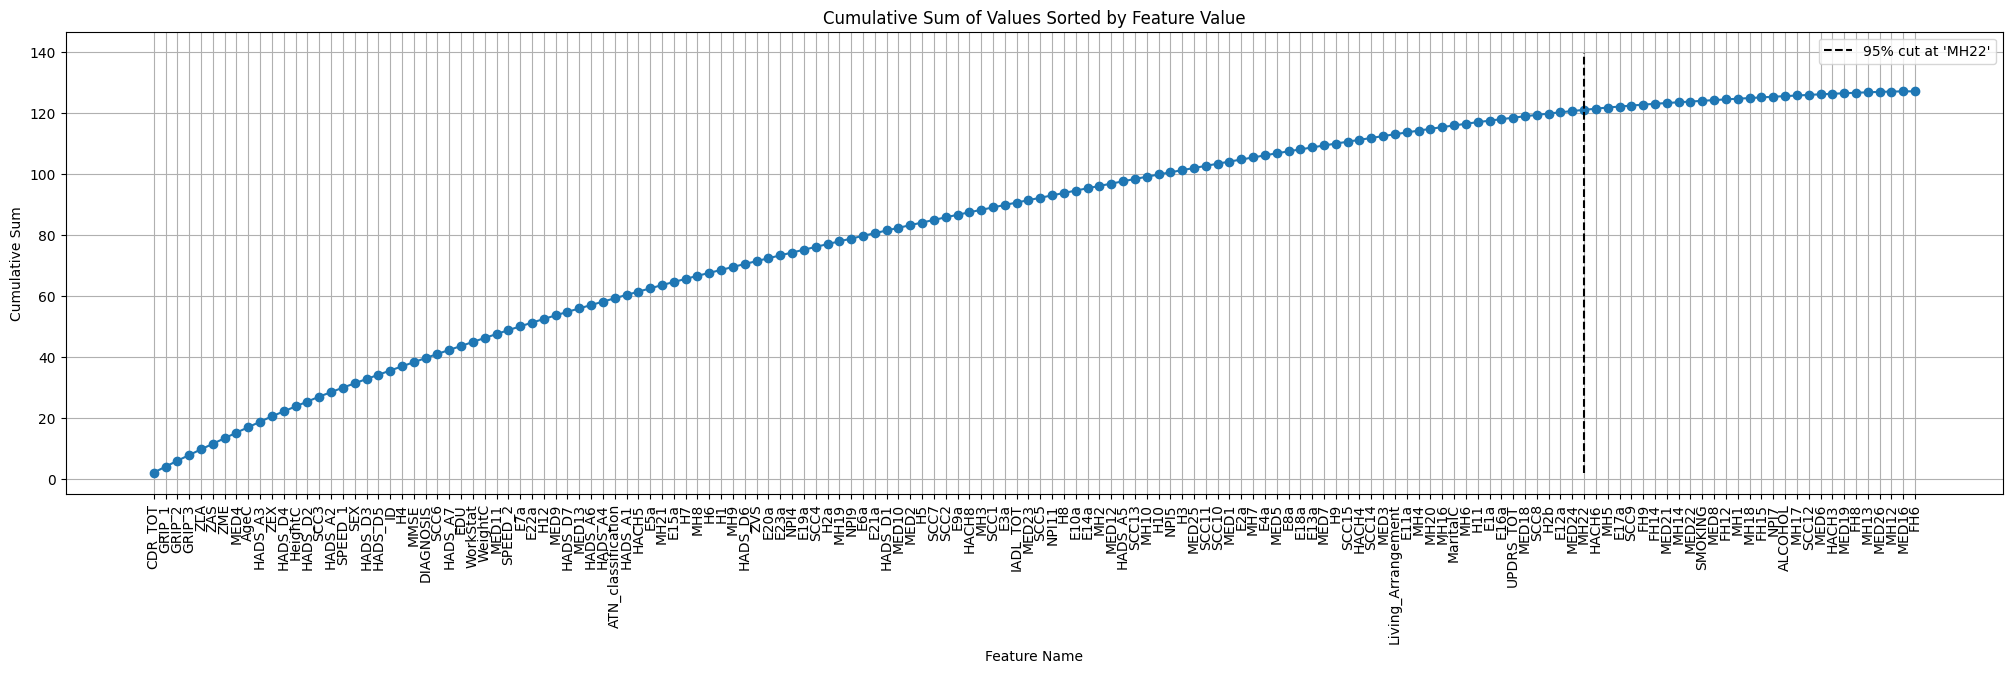

In [13]:
# Print the limit feature
print(f"\nLimit feature (where 95% cumulative sum is reached or fallback): {limit_feature}")

# Plotting
plt.figure(figsize=(25,6))
plt.plot(sorted_df_model_1_visit['feature_name'], sorted_df_model_1_visit['cumulative_sum'], marker='o')
plt.vlines(
    x=limit_feature,
    ymin=sorted_df_model_1_visit['cumulative_sum'].min(),
    ymax=1.1 * sorted_df_model_1_visit['cumulative_sum'].max(),
    label=f"95% cut at '{limit_feature}'",
    linestyles="dashed",
    color='black'
)
plt.xlabel('Feature Name')
plt.ylabel('Cumulative Sum')
plt.title('Cumulative Sum of Values Sorted by Feature Value')
plt.xticks(rotation=90)
plt.legend()
plt.grid(True)
plt.show()

In [15]:
# Remove unimportant features, in terms of mutual information and Spearman correlation
features_to_drop_model_1_visit = filtered_df_model_1_visit['feature_name'].tolist()

df_model_1_visit = df_model_1_visit.drop(columns=features_to_drop_model_1_visit)
train_df_model_1_visit = train_df_model_1_visit.drop(columns=features_to_drop_model_1_visit)
test_df_model_1_visit = test_df_model_1_visit.drop(columns=features_to_drop_model_1_visit)

In [16]:
df_model_1_visit = df_model_1_visit.drop(columns=["GRIP_2", "GRIP_3", "E1a","E23a", "H7", "E8a", "MH2", "SCC4"]) # Manually selected from the next step, features that had correlation >0.85

corr_matrix_model_1_visit = df_model_1_visit.corr()

corr_unstacked_model_1_visit = corr_matrix_model_1_visit.unstack()

# Convert to a DataFrame and reset index
corr_df_model_1_visit = pd.DataFrame(corr_unstacked_model_1_visit, columns=['correlation']).reset_index()

# Rename the columns for better understanding
corr_df_model_1_visit.columns = ['Variable_1', 'Variable_2', 'correlation']

# Remove self-correlations
corr_df_model_1_visit = corr_df_model_1_visit[corr_df_model_1_visit['Variable_1'] != corr_df_model_1_visit['Variable_2']]

# Drop duplicate pairs
corr_df_model_1_visit['pair'] = corr_df_model_1_visit.apply(lambda row: tuple(sorted([row['Variable_1'], row['Variable_2']])), axis=1)
corr_df_model_1_visit = corr_df_model_1_visit.drop_duplicates(subset=['pair'])

# Drop the 'pair' column as it's no longer needed
corr_df_model_1_visit = corr_df_model_1_visit.drop(columns=['pair'])

# Sort by correlation value in descending order
corr_df_model_1_visit = corr_df_model_1_visit.sort_values(by='correlation', ascending=False)


In [17]:
corr_df_model_1_visit[corr_df_model_1_visit['correlation'] > 0.85] 

,Variable_1,Variable_2,correlation


In [18]:
# Manually selected from the step before, features that had correlation >0.85
train_df_model_1_visit = train_df_model_1_visit.drop(columns=["GRIP_2", "GRIP_3", "E1a","E23a", "H7", "E8a", "MH2", "SCC4"])
test_df_model_1_visit = test_df_model_1_visit.drop(columns=["GRIP_2", "GRIP_3", "E1a","E23a", "H7", "E8a", "MH2", "SCC4"])

## Train and test split

In [19]:
# Separate the ID for reference
train_ids_model_1_visit = train_df_model_1_visit['ID'].astype(str) + '_visit1'
test_ids_model_1_visit = test_df_model_1_visit['ID'].astype(str) + '_visit1'

# Define features and target variable for model training (excluding 'ID')
X_train_model_1_visit = train_df_model_1_visit.drop(columns=['DIAGNOSIS', 'ID'])
y_train_model_1_visit = train_df_model_1_visit['DIAGNOSIS']

X_test_model_1_visit = test_df_model_1_visit.drop(columns=['DIAGNOSIS', 'ID'])
y_test_model_1_visit = test_df_model_1_visit['DIAGNOSIS']

## Model

  0%|          | 0/8 [00:00<?, ?trial/s, best loss=?]

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:46:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:46:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:46:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 12%|█▎        | 1/8 [00:00<00:03,  2.12trial/s, best loss: -0.8894894894894895]

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:46:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:46:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:46:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:46:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_labe

 25%|██▌       | 2/8 [00:00<00:02,  2.07trial/s, best loss: -0.895045045045045] 

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:46:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:46:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:46:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:46:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_labe

 38%|███▊      | 3/8 [00:01<00:01,  2.78trial/s, best loss: -0.895045045045045]

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:46:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:46:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:46:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:46:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_labe

 50%|█████     | 4/8 [00:01<00:01,  2.85trial/s, best loss: -0.895045045045045]

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:46:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:46:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:46:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:46:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_labe

 62%|██████▎   | 5/8 [00:01<00:00,  3.15trial/s, best loss: -0.895045045045045]

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:46:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:46:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:46:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:46:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_labe

 75%|███████▌  | 6/8 [00:02<00:00,  3.35trial/s, best loss: -0.895045045045045]

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:46:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:46:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:46:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:46:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_labe

 88%|████████▊ | 7/8 [00:02<00:00,  2.24trial/s, best loss: -0.895045045045045]

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:46:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:46:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:46:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:46:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_labe

100%|██████████| 8/8 [00:03<00:00,  2.40trial/s, best loss: -0.895045045045045]
Best hyperparameters: {'colsample_bytree': np.float64(0.6315933119342986), 'eta': np.float64(0.11309157989114597), 'max_depth': np.float64(8.0), 'min_child_weight': np.float64(9.0), 'n_estimators': np.float64(320.0), 'subsample': np.float64(0.7201685419162033)}
[0]	validation_0-logloss:0.61690
[1]	validation_0-logloss:0.58876
[2]	validation_0-logloss:0.53853
[3]	validation_0-logloss:0.50494
[4]	validation_0-logloss:0.48817
[5]	validation_0-logloss:0.45436
[6]	validation_0-logloss:0.43203
[7]	validation_0-logloss:0.40413
[8]	validation_0-logloss:0.38302
[9]	validation_0-logloss:0.36618
[10]	validation_0-logloss:0.34662
[11]	validation_0-logloss:0.33014
[12]	validation_0-logloss:0.32908
[13]	validation_0-logloss:0.31881
[14]	validation_0-logloss:0.30905
[15]	validation_0-logloss:0.30880
[16]	validation_0-logloss:0.30013
[17]	validation_0-logloss:0.30009
[18]	validation_0-logloss:0.30040
[19]	validation_0-logl

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:46:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:46:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Test Set Accuracy: 0.9166666666666666
Test Set Confusion Matrix:
[[28  3]
 [ 1 16]]
Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.90      0.93        31
           1       0.84      0.94      0.89        17

    accuracy                           0.92        48
   macro avg       0.90      0.92      0.91        48
weighted avg       0.92      0.92      0.92        48

Test Set MCC: 0.8258076542511829


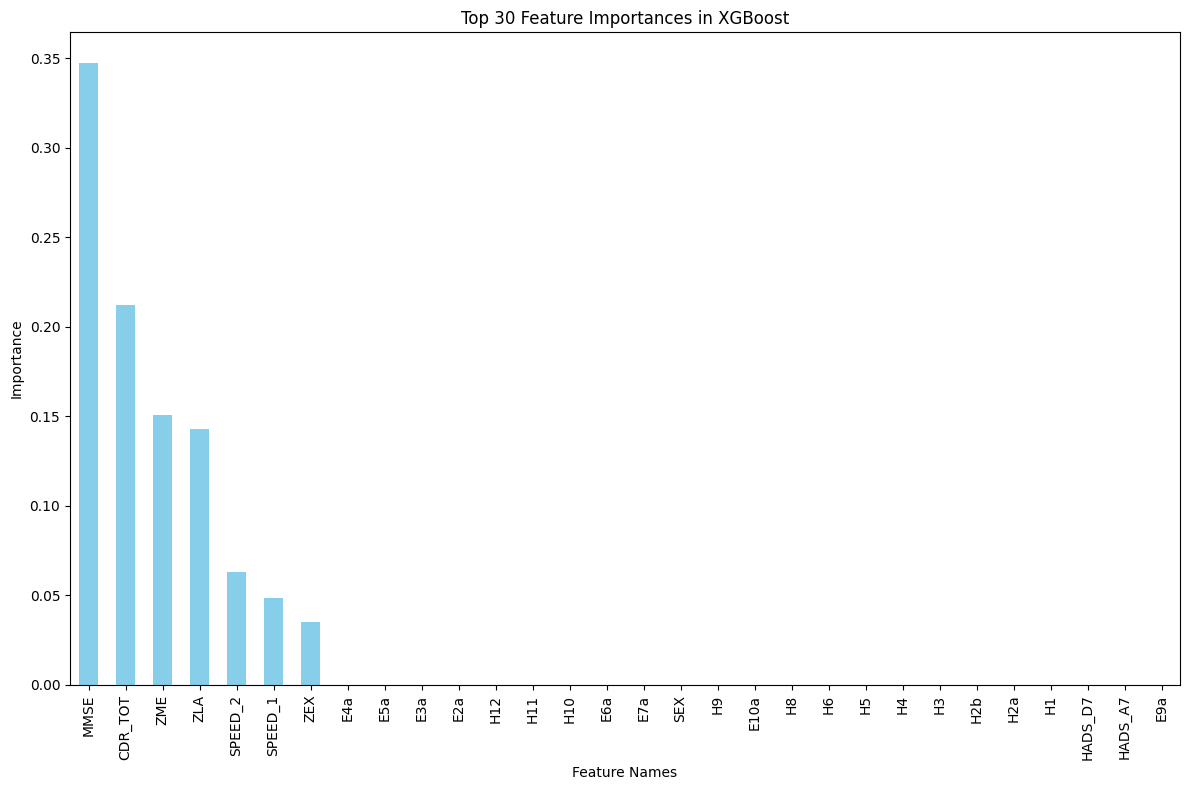

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:46:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:46:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:46:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:46:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_e

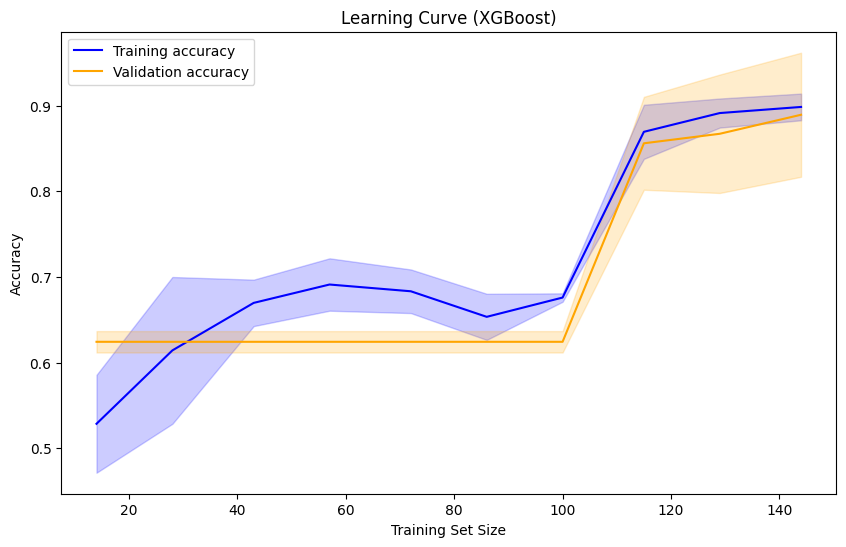

In [20]:
# Define the objective function for Hyperopt
def objective(params):
    params['max_depth'] = int(params['max_depth'])
    params['min_child_weight'] = int(params['min_child_weight'])
    params['n_estimators'] = int(params['n_estimators'])

    model = XGBClassifier(
        **params,
        use_label_encoder=False,
        random_state=random_seed,
        verbosity=1
    )
    # Perform cross-validation
    scores = cross_val_score(model, X_train_model_1_visit, y_train_model_1_visit, cv=5, scoring='accuracy')
    return -np.mean(scores)

# Define the search space for XGBClassifier parameters
space = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'eta': hp.loguniform('eta', -5, 0),
    'max_depth': scope.int(hp.quniform('max_depth', 5, 50, 1)),
    'min_child_weight': scope.int(hp.quniform('min_child_weight', 1, 10, 1)),
    'subsample': hp.uniform('subsample', 0.6, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),
    'n_estimators': scope.int(hp.quniform('n_estimators', 50, 500, 10)),
}

# Run the optimization with Hyperopt
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=8, trials=trials, rstate=np.random.default_rng(random_seed))

print(f"Best hyperparameters: {best}")

# Convert the best params for training
best_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'eta': best['eta'],
    'max_depth': int(best['max_depth']),
    'min_child_weight': int(best['min_child_weight']),
    'subsample': best['subsample'],
    'colsample_bytree': best['colsample_bytree'],
    'n_estimators': int(best['n_estimators']),
    'random_state': random_seed,
    'use_label_encoder': False,
    'early_stopping_rounds': 10,
}

# Train the model
xgboost_model1 = XGBClassifier(**best_params)
xgboost_model1.fit(X_train_model_1_visit, y_train_model_1_visit, eval_set=[(X_test_model_1_visit, y_test_model_1_visit)], verbose=True)

# Make predictions
y_pred_prob_model1 = xgboost_model1.predict_proba(X_test_model_1_visit)[:, 1]
y_pred_model1 = (y_pred_prob_model1 > 0.5).astype(int)

# Evaluate the model
accuracy_model1 = accuracy_score(y_test_model_1_visit, y_pred_model1)
conf_matrix_model1 = confusion_matrix(y_test_model_1_visit, y_pred_model1)
class_report_model1 = classification_report(y_test_model_1_visit, y_pred_model1)
mcc_model1 = matthews_corrcoef(y_test_model_1_visit, y_pred_model1)

print(f"Test Set Accuracy: {accuracy_model1}")
print("Test Set Confusion Matrix:")
print(conf_matrix_model1)
print("Test Set Classification Report:")
print(class_report_model1)
print(f"Test Set MCC: {mcc_model1}")

# Feature importance analysis
feature_importances_model1 = xgboost_model1.feature_importances_
feature_names_model1 = X_train_model_1_visit.columns if hasattr(X_train_model_1_visit, 'columns') else [f"Feature {i}" for i in range(X_train_model_1_visit.shape[1])]
feat_importances_model1 = pd.Series(feature_importances_model1, index=feature_names_model1)
feat_importances_model1 = feat_importances_model1.sort_values(ascending=False)

# Plot top 30 feature importances
plt.figure(figsize=(12, 8))
feat_importances_model1[:30].plot(kind='bar', color='skyblue')
plt.title('Top 30 Feature Importances in XGBoost')
plt.ylabel('Importance')
plt.xlabel('Feature Names')
plt.tight_layout()
plt.show()

# Remove `early_stopping_rounds` for the learning curve
params_for_learning_curve_model1 = {key: value for key, value in best_params.items() if key != 'early_stopping_rounds'}

# Generate the learning curve
train_sizes_model1, train_scores_model1, val_scores_model1 = learning_curve(
    XGBClassifier(**params_for_learning_curve_model1),
    X_train_model_1_visit,
    y_train_model_1_visit,
    cv=5,
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10),
    random_state=random_seed
)

# Calculate means and standard deviations
train_scores_mean = np.mean(train_scores_model1, axis=1)
train_scores_std = np.std(train_scores_model1, axis=1)
val_scores_mean = np.mean(val_scores_model1, axis=1)
val_scores_std = np.std(val_scores_model1, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes_model1, train_scores_mean, label='Training accuracy', color='blue')
plt.fill_between(train_sizes_model1, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color='blue')
plt.plot(train_sizes_model1, val_scores_mean, label='Validation accuracy', color='orange')
plt.fill_between(train_sizes_model1, val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, alpha=0.2, color='orange')
plt.title('Learning Curve (XGBoost)')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Individual Predictions

In [21]:
# Create a DataFrame to store the test IDs, true labels, and predictions
predictions_df_model_1_visit = pd.DataFrame({
    'ID': test_ids_model_1_visit,           # Use the test IDs from earlier
    'True_Label': y_test_model_1_visit,     # True labels from the test set
    'Predicted_Label': y_pred_model1 # Predicted labels from the model
})

predictions_df_model_1_visit

# Analyze mismatches (where true label != predicted label)
mismatches_model_1_visit = predictions_df_model_1_visit[predictions_df_model_1_visit['True_Label'] != predictions_df_model_1_visit['Predicted_Label']]
print("Mismatches:")
print(mismatches_model_1_visit)


Mismatches:
             ID  True_Label  Predicted_Label
1   6050_visit1           1                0
22  6987_visit1           0                1
32  7323_visit1           0                1
47  8575_visit1           0                1


In [22]:
# Save predictions for ensemble
predictions_df_model_1_visit.to_csv('predictions_model_visit1.csv', index=False)

## Individual Explainer Dashboard

In [28]:
# Create an explainer object
explainer_model_1_visit = ClassifierExplainer(xgboost_model1, X_test_model_1_visit, y_test_model_1_visit,
                                labels = ["NC", "MCI"],
                                target = "DIAGNOSIS",
                                index_name = "Participant",
                                idxs = test_ids_model_1_visit,
                                model_output="logodds", 
                                )

# Initialize the dashboard
dashboard_model_1_visit = ExplainerDashboard(explainer_model_1_visit, 
                        title="Model 1 (XGBoost) - 1st Visit", # defaults to "Model Explainer"
                        # importances=True,
                        # model_summary=True,
                        # hide_globalcutoff=True, hide_precision=True, hide_classification=True, hide_cumprecision=True,
                        # contributions=True,
                        # hide_pdp=True, 
                        # whatif=True,
                        # hide_whatifpdp=True,
                        # shap_dependence=True,
                        #shap_interaction=True,
                        # decision_trees=False,
                        # hide_poweredby=True,
                        # hide_depth=True,
                        # hide_sort=True,
                        # permutation_importance=True,
                        )

# Run the dashboard (this will start a web server)
dashboard_model_1_visit.run(port=8005)

Detected XGBClassifier model: Changing class type to XGBClassifierExplainer...
Generating self.shap_explainer = shap.TreeExplainer(model)
Building ExplainerDashboard..
Detected notebook environment, consider setting mode='external', mode='inline' or mode='jupyterlab' to keep the notebook interactive while the dashboard is running...
Generating layout...
Calculating shap values...
Calculating prediction probabilities...
Calculating metrics...
Calculating confusion matrices...
Calculating classification_dfs...
Calculating roc auc curves...
Calculating pr auc curves...
Calculating liftcurve_dfs...
Calculating shap interaction values... (this may take a while)
Reminder: TreeShap computational complexity is O(TLD^2), where T is the number of trees, L is the maximum number of leaves in any tree and D the maximal depth of any tree. So reducing these will speed up the calculation.
Generating xgboost model dump...
Calculating dependencies...
Calculating permutation importances (if slow, try set

Empty DataFrame
Columns: [col, contribution, value]
Index: []
Empty DataFrame
Columns: [col, contribution, value]
Index: []


/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/explainerdashboard/explainer_methods.py:68: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/dtreeviz/models/shadow_decision_tree.py:335: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/dtreeviz/trees.py:420: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consis

# Model on 1st and 2nd visit

In [27]:
# Reload data of visit 1
test_df_visit1 = pd.read_csv("../data/test_df_imputed_1stvisit.csv")
train_df_visit1 = pd.read_csv("../data/train_df_imputed_1stvisit.csv")

# Load data of visit 2
test_df_visit2 = pd.read_csv("../data/test_df_imputed_2ndvisit.csv")
train_df_visit2 = pd.read_csv("../data/train_df_imputed_2ndvisit.csv")

# Create copies of the original dataframes
test_df_visit1_copy = test_df_visit1.copy()
train_df_visit1_copy = train_df_visit1.copy()
test_df_visit2_copy = test_df_visit2.copy()
train_df_visit2_copy = train_df_visit2.copy()

In [28]:
# Add VisitNuA column
test_df_visit1["VisitNuA"] = 0
train_df_visit1["VisitNuA"] = 0
test_df_visit2["VisitNuA"] = 1
train_df_visit2["VisitNuA"] = 1

# Ensure consistent column order
all_columns = list(set(test_df_visit1.columns).union(set(test_df_visit2.columns)))

# Add missing columns to visit2 datasets
for col in all_columns:
    if col not in test_df_visit2.columns:
        test_df_visit2[col] = 999
    if col not in train_df_visit2.columns:
        train_df_visit2[col] = 999

# Add missing columns to visit1 datasets
for col in all_columns:
    if col not in test_df_visit1.columns:
        test_df_visit1[col] = 999
    if col not in train_df_visit1.columns:
        train_df_visit1[col] = 999

# Ensure column order matches
test_df_visit2 = test_df_visit2[all_columns]
train_df_visit2 = train_df_visit2[all_columns]

# Concatenate datasets
merged_test_df = pd.concat([test_df_visit1, test_df_visit2], ignore_index=True)
merged_train_df = pd.concat([train_df_visit1, train_df_visit2], ignore_index=True)


In [30]:
# Hospital suggested to remove these features
train_df_model_12_visit = merged_train_df.drop(columns=features_to_remove)
test_df_model_12_visit = merged_test_df.drop(columns=features_to_remove)

In [33]:
# Fix data types
test_df_model_12_visit[categorical_columns] = test_df_model_12_visit[categorical_columns].astype('category')
train_df_model_12_visit[categorical_columns] = train_df_model_12_visit[categorical_columns].astype('category')
test_df_model_12_visit[categorical_columns] = test_df_model_12_visit[categorical_columns].apply(lambda col: col.cat.codes)
train_df_model_12_visit[categorical_columns] = train_df_model_12_visit[categorical_columns].apply(lambda col: col.cat.codes)

test_df_model_12_visit[int_columns] = test_df_model_12_visit[int_columns].astype(int)
train_df_model_12_visit[int_columns] = train_df_model_12_visit[int_columns].astype(int)

## Obtain features that should be removed based on visit 2

In [34]:
# Hospital suggested to remove these features
features_to_remove_visit2 = ["NPI_TOT", "CDR1", "CDR2", "CDR3", "CDR4", "CDR5", "CDR6", "IADL1", "IADL2", 
    "IADL3", "IADL4", "IADL5", "IADL6", "IADL7", "IADL8", "HACH_TOT", "UPDRS1", "UPDRS2", "UPDRS3a", "UPDRS3b", "UPDRS3c", 
    "UPDRS3d", "UPDRS3e", "UPDRS4a", "UPDRS4b", "UPDRS5a", "UPDRS5b", "UPDRS5c", "UPDRS5d", "UPDRS5e", 
    "UPDRS6a", "UPDRS6b", "UPDRS7a", "UPDRS7b", "UPDRS8a", "UPDRS8b", "UPDRS9a", "UPDRS9b", "UPDRS10", 
    "UPDRS11", "UPDRS12", "UPDRS13", "UPDRS14",]

train_df_visit2_copy = train_df_visit2_copy.drop(columns=features_to_remove_visit2)
test_df_visit2_copy = test_df_visit2_copy.drop(columns=features_to_remove_visit2)

In [35]:
# Necessary for feature refinement step
df_visit2 = pd.concat([train_df_visit2_copy, test_df_visit2_copy], axis=0)

In [37]:
# Fix data types
categorical_columns_visit2 = ["ΜaritalC", "Living_Arrangement", "WorkStat"]

int_columns_visit2 = ["SEX", "EDU", "AgeC", "MH1", "MH2", "MH3", "MH4", "MH5", "MH6", "MH7", 
    "MH8", "MH9", "MH10", "MH11", "MH12", "MH13", "MH14", "MH15", "MH16", "MH17", "MH18", "MH19", 
    "MH20", "MH21", "MH22", "SMOKING", "ALCOHOL", "MED1", "MED2", "MED3", "MED4", "MED5", "MED6", 
    "MED7", "MED8", "MED9", "MED10", "MED11", "MED12", "MED13", "MED14", "MED15", "MED16", "MED17", 
    "MED18", "MED19", "MED20", "MED21", "MED22", "MED23", "MED24", "MED25", "MED26", "FH5", "FH6", "FH7", "FH8", "FH9", "FH10", "FH11", "FH12", "FH13", "FH14", "FH15", 
    "FH16", "NPI1", "NPI2", "NPI3", "NPI4", "NPI5", "NPI6", "NPI7", "NPI8", "NPI9", "NPI10", "NPI11", 
    "NPI12", "IADL_TOT", "HACH1", "HACH2", "HACH3", "HACH4", 
    "HACH5", "HACH6", "HACH7", "HACH8", "UPDRS_TOT", "DIAGNOSIS"
    ]

df_visit2[categorical_columns_visit2] = df_visit2[categorical_columns_visit2].astype('category')
test_df_visit2_copy[categorical_columns_visit2] = test_df_visit2_copy[categorical_columns_visit2].astype('category')
train_df_visit2_copy[categorical_columns_visit2] = train_df_visit2_copy[categorical_columns_visit2].astype('category')
df_visit2[categorical_columns_visit2] = df_visit2[categorical_columns_visit2].apply(lambda col: col.cat.codes)
test_df_visit2_copy[categorical_columns_visit2] = test_df_visit2_copy[categorical_columns_visit2].apply(lambda col: col.cat.codes)
train_df_visit2_copy[categorical_columns_visit2] = train_df_visit2_copy[categorical_columns_visit2].apply(lambda col: col.cat.codes)

df_visit2[int_columns_visit2] = df_visit2[int_columns_visit2].astype(int)

In [40]:
# Remove features with a constant value
constant_columns_visit2 = [col for col in df_visit2.columns if df_visit2[col].nunique() == 1]
df_visit2 = df_visit2.drop(labels=constant_columns_visit2, axis=1)

In [42]:
X_visit2 = df_visit2.values
feature_names_visit2 = df_visit2.columns

# Calculate the Spearman correlation matrix
spearman_corr_matrix_visit2 = np.empty((X_visit2.shape[1], X_visit2.shape[1]))
for i in range(X_visit2.shape[1]):
    for j in range(X_visit2.shape[1]):
        spearman_corr_matrix_visit2[i, j], _ = spearmanr(X_visit2[:, i], X_visit2[:, j])

# Print the Spearman correlation matrix
print("Spearman correlation matrix:")
print(spearman_corr_matrix_visit2)

# Calculate the mutual information
mutual_info_matrix_visit2 = np.empty((X_visit2.shape[1], X_visit2.shape[1]))
for i in range(X_visit2.shape[1]):
    mutual_info_matrix_visit2[i] = mutual_info_regression(X_visit2, X_visit2[:, i], random_state=29)

# Print the mutual information matrix
print("\nMutual information matrix:")
print(mutual_info_matrix_visit2)

# Compute the average absolute value of the correlations
avg_spearman_corr_visit2 = np.mean(np.abs(spearman_corr_matrix_visit2), axis=0)
avg_mutual_info_visit2 = np.mean(np.abs(mutual_info_matrix_visit2), axis=0)

# Print average Spearman correlation and mutual information
print("\nAverage Spearman correlation:")
print(avg_spearman_corr_visit2)
print("\nAverage mutual information:")
print(avg_mutual_info_visit2)

# Combine the two averaged correlations
combined_corr_visit2 = avg_spearman_corr_visit2 + avg_mutual_info_visit2

# Print combined correlation
print("\nCombined correlation (Spearman + Mutual Info):")
print(combined_corr_visit2)

# Scale the combined values between 0 and 1
scaler_visit2 = MinMaxScaler()
scaled_combined_corr_visit2 = scaler_visit2.fit_transform(combined_corr_visit2.reshape(-1, 1)).flatten()

# Print scaled combined correlation
print("\nScaled combined correlation:")
print(scaled_combined_corr_visit2)

# Sum the scaled values for each feature
final_values_visit2 = scaled_combined_corr_visit2 + scaled_combined_corr_visit2

# Print final values for each feature
print("\nFinal values (scaled combined correlation + itself):")
print(final_values_visit2)

# Create the resulting DataFrame
result_df_visit2 = pd.DataFrame({
    'feature_name': feature_names_visit2,
    'value': final_values_visit2
})

# Sort the DataFrame by the 'value' column
sorted_df_visit2 = result_df_visit2.sort_values('value', ascending=False)

# Print the sorted DataFrame
print("\nSorted DataFrame:")
print(sorted_df_visit2)

# Compute the cumulative sum of the 'value' column
sorted_df_visit2['cumulative_sum'] = sorted_df_visit2['value'].cumsum()

# Print the DataFrame with cumulative sum
print("\nDataFrame with cumulative sum:")
print(sorted_df_visit2)

# Check if any rows meet the 95% cumulative sum threshold
filtered_df_visit2 = sorted_df_visit2[sorted_df_visit2['cumulative_sum'] > 0.95 * sorted_df_visit2['cumulative_sum'].max()]

# Print the filtered DataFrame and check if it's empty
print("\nFiltered DataFrame (cumulative sum > 90% of total):")
print(filtered_df_visit2)

# If the filtered DataFrame is not empty, proceed
if not filtered_df_visit2.empty:
    limit_feature = filtered_df_visit2['feature_name'].iloc[0]
else:
    # Fallback option: if no feature meets the 90% threshold, take the last feature
    limit_feature = sorted_df_visit2['feature_name'].iloc[-1]



Spearman correlation matrix:
[[ 1.00000000e+00  8.99622831e-02  2.17224482e-01 ...  1.99281146e-01
   1.71932475e-01 -1.17619063e-01]
 [ 8.99622831e-02  1.00000000e+00  7.55370935e-04 ...  1.01907898e-02
   1.04376837e-02 -2.08376609e-01]
 [ 2.17224482e-01  7.55370935e-04  1.00000000e+00 ...  3.50224036e-01
   3.98765202e-01 -2.91882710e-01]
 ...
 [ 1.99281146e-01  1.01907898e-02  3.50224036e-01 ...  1.00000000e+00
   5.81374991e-01 -3.76226640e-01]
 [ 1.71932475e-01  1.04376837e-02  3.98765202e-01 ...  5.81374991e-01
   1.00000000e+00 -4.38228834e-01]
 [-1.17619063e-01 -2.08376609e-01 -2.91882710e-01 ... -3.76226640e-01
  -4.38228834e-01  1.00000000e+00]]

Mutual information matrix:
[[3.53278013 0.01111069 0.08519866 ... 0.01332801 0.         0.09589651]
 [0.01019242 0.63503741 0.         ... 0.01183067 0.         0.02414638]
 [0.10169714 0.         2.02773926 ... 0.12753404 0.16846136 0.0449362 ]
 ...
 [0.01036751 0.027735   0.09100723 ... 3.42264633 0.20246145 0.05382351]
 [0.      


Limit feature (where 95% cumulative sum is reached or fallback): MED3


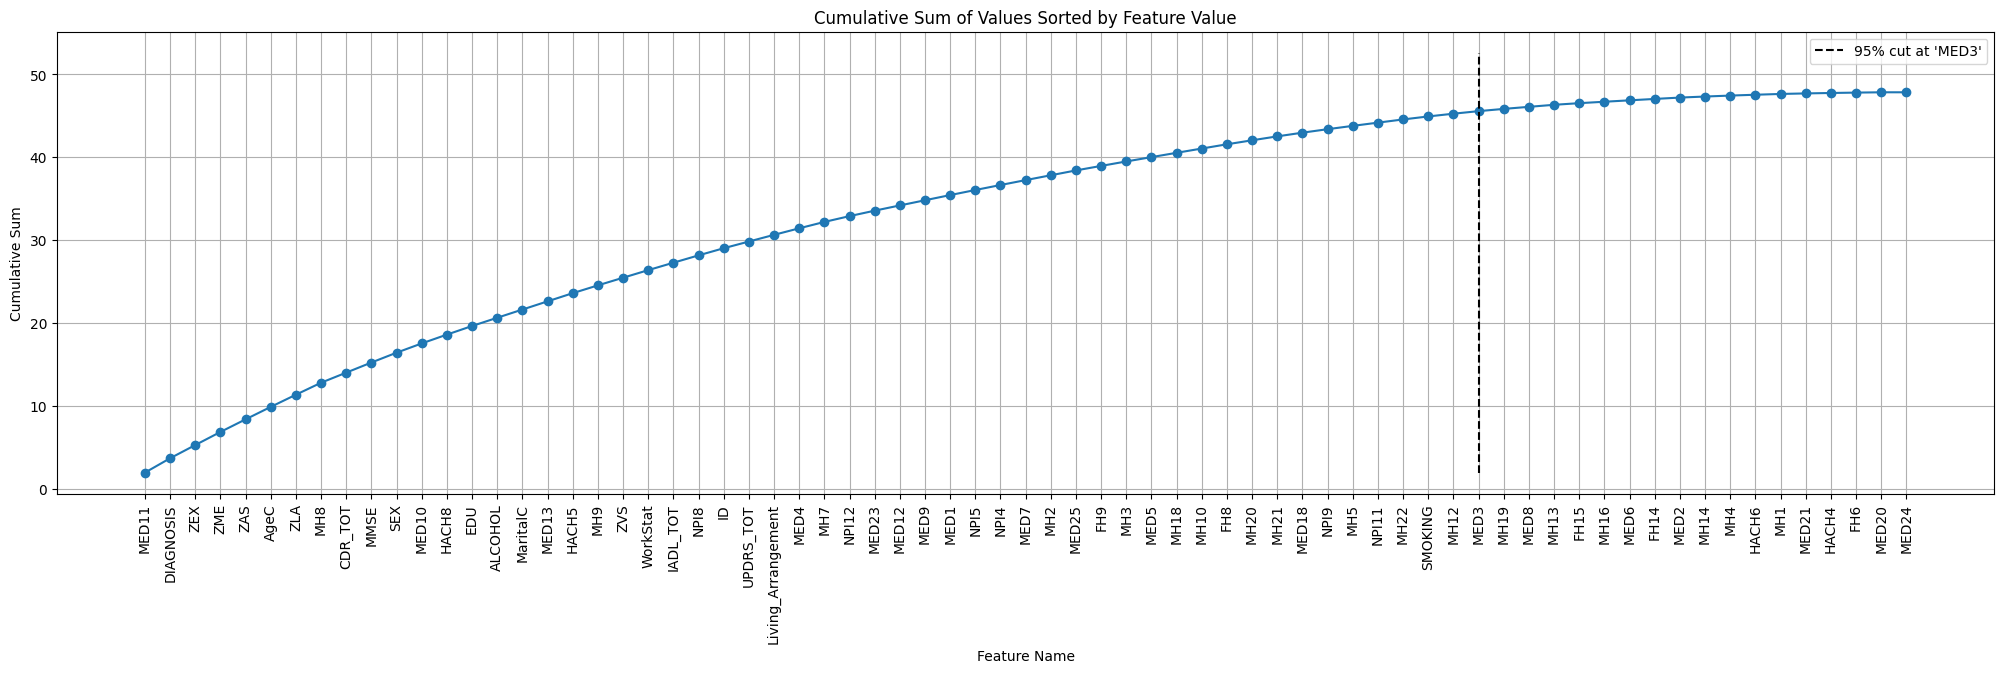

In [43]:
# Print the limit feature
print(f"\nLimit feature (where 95% cumulative sum is reached or fallback): {limit_feature}")

# Plotting
plt.figure(figsize=(25,6))
plt.plot(sorted_df_visit2['feature_name'], sorted_df_visit2['cumulative_sum'], marker='o')
plt.vlines(
    x=limit_feature,
    ymin=sorted_df_visit2['cumulative_sum'].min(),
    ymax=1.1 * sorted_df_visit2['cumulative_sum'].max(),
    label=f"95% cut at '{limit_feature}'",
    linestyles="dashed",
    color='black'
)
plt.xlabel('Feature Name')
plt.ylabel('Cumulative Sum')
plt.title('Cumulative Sum of Values Sorted by Feature Value')
plt.xticks(rotation=90)
plt.legend()
plt.grid(True)
plt.show()

In [46]:
# Remove unimportant features, in terms of mutual information and Spearman correlation
features_to_drop_visit2 = filtered_df_visit2['feature_name'].tolist()
df_visit2 = df_visit2.drop(columns=features_to_drop_visit2)

In [48]:
df_visit2 = df_visit2.drop(columns=["MH2", "MH8", "HACH5"]) # Manually selected from the next step, features that had correlation >0.85

corr_matrix_visit2 = df_visit2.corr()

corr_unstacked_visit2= corr_matrix_visit2.unstack()

# Convert to a DataFrame and reset index
corr_df_visit2 = pd.DataFrame(corr_unstacked_visit2, columns=['correlation']).reset_index()

# Rename the columns for better understanding
corr_df_visit2.columns = ['Variable_1', 'Variable_2', 'correlation']

# Remove self-correlations
corr_df_visit2 = corr_df_visit2[corr_df_visit2['Variable_1'] != corr_df_visit2['Variable_2']]

# Drop duplicate pairs
corr_df_visit2['pair'] = corr_df_visit2.apply(lambda row: tuple(sorted([row['Variable_1'], row['Variable_2']])), axis=1)
corr_df_visit2 = corr_df_visit2.drop_duplicates(subset=['pair'])

# Drop the 'pair' column as it's no longer needed
corr_df_visit2 = corr_df_visit2.drop(columns=['pair'])

# Sort by correlation value in descending order
corr_df_visit2 = corr_df_visit2.sort_values(by='correlation', ascending=False)


In [49]:
corr_df_visit2[corr_df_visit2['correlation'] > 0.85] 

,Variable_1,Variable_2,correlation


## Final feature removal

In [53]:
# Earlier feature selection steps have identified the following features as highly correlated
correlated_features_model_12_visit = ["MH2", "MH8", "HACH5"] + ["GRIP_2", "GRIP_3", "E1a", "E23a", "H7", "E8a", "MH2", "SCC4"]

# Combine all features to drop
unique_features_to_drop_model_12_visit = list(set(features_to_drop_model_1_visit + features_to_drop_visit2 + constant_columns_model_1_visit + constant_columns_visit2 + correlated_features_model_12_visit))

# Exclude VisitNuA
unique_features_to_drop_model_12_visit.remove("VisitNuA")

train_df_model_12_visit = train_df_model_12_visit.drop(labels=unique_features_to_drop_model_12_visit, axis=1)
test_df_model_12_visit = test_df_model_12_visit.drop(labels=unique_features_to_drop_model_12_visit, axis=1)

## Train and test split

In [54]:
# Separate the ID for reference
train_ids_model_12_visit = train_df_model_12_visit['ID'].astype(str) + '_visit' + (train_df_model_12_visit['VisitNuA'] + 1).astype(str)
test_ids_model_12_visit = test_df_model_12_visit['ID'].astype(str) + '_visit' + (test_df_model_12_visit['VisitNuA'] + 1).astype(str)

# Define features and target variable for model training (excluding 'ID')
X_train_model_12_visit = train_df_model_12_visit.drop(columns=['DIAGNOSIS', 'ID'])
y_train_model_12_visit = train_df_model_12_visit['DIAGNOSIS']

X_test_model_12_visit = test_df_model_12_visit.drop(columns=['DIAGNOSIS', 'ID'])
y_test_model_12_visit = test_df_model_12_visit['DIAGNOSIS']

## Model

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, class_weight=None, max_depth=15, max_features=log2, min_samples_leaf=8, min_samples_split=20, n_estimators=200;

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/numpy/ma/core.py:2846: RuntimeWarning:

invalid value encountered in cast



Cross-validation scores: [0.89285714 0.92857143 0.92857143 0.91071429 0.85454545]
Mean cross-validation score: 0.903051948051948
Cross-validation Accuracy: 0.9032258064516129
Cross-validation Confusion Matrix:
[[180   5]
 [ 22  72]]
Cross-validation Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.97      0.93       185
           1       0.94      0.77      0.84        94

    accuracy                           0.90       279
   macro avg       0.91      0.87      0.89       279
weighted avg       0.91      0.90      0.90       279

Cross-validation MCC: 0.781326023193409
Test Set Accuracy: 0.9154929577464789
Test Set Confusion Matrix:
[[45  4]
 [ 2 20]]
Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.92      0.94        49
           1       0.83      0.91      0.87        22

    accuracy                           0.92        71
   macro avg       0.90   

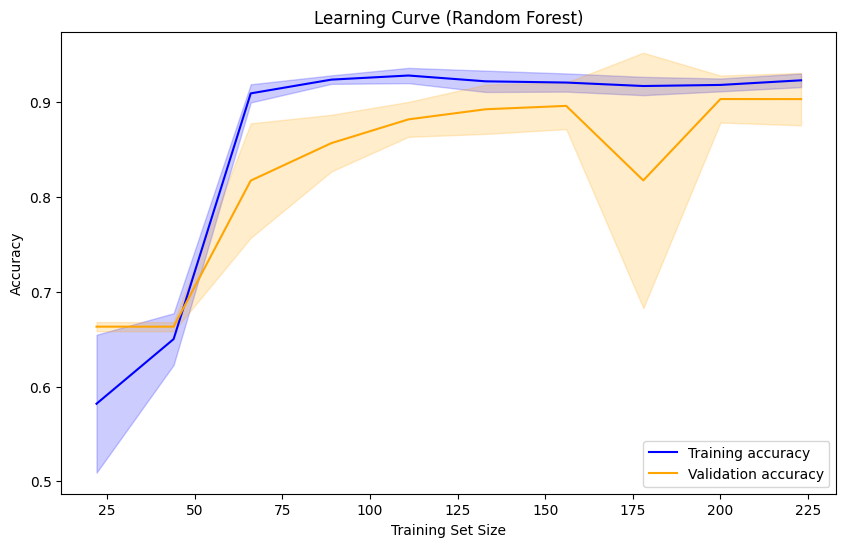

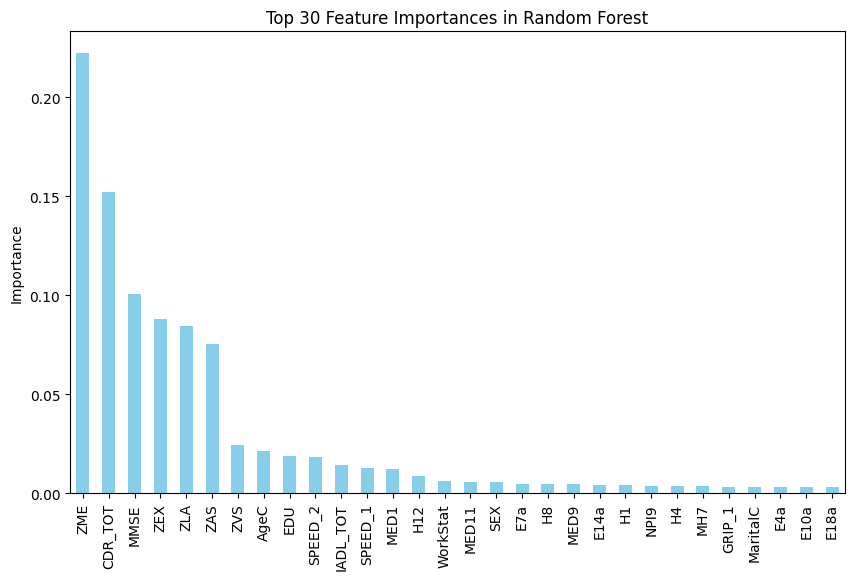

In [55]:
# Define a parameter grid for RandomizedSearchCV
param_grid_model_12_visit = {
    'n_estimators': [50, 100, 150, 200, 300],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [10, 15, 20, 25, 30],
    'min_samples_split': [10, 15, 20, 30],
    'min_samples_leaf': [4, 6, 8, 10, 15],
    'bootstrap': [True],
    'class_weight': [None, 'balanced'],
}

# Initialize the Random Forest Classifier
rf_model_12_visit = RandomForestClassifier(random_state=0)

# Initialize RandomizedSearchCV
rf_random_model_12_visit = RandomizedSearchCV(estimator=rf_model_12_visit, param_distributions=param_grid_model_12_visit, 
                               n_iter=200, cv=5, verbose=2, random_state=42, n_jobs=-1)

# Fit the randomized search model
rf_random_model_12_visit.fit(X_train_model_12_visit, y_train_model_12_visit)

# Get the best estimator
best_rf_model_12_visit = rf_random_model_12_visit.best_estimator_

# Perform cross-validation with the best estimator
cv_scores_model_12_visit = cross_val_score(best_rf_model_12_visit, X_train_model_12_visit, y_train_model_12_visit, cv=5)
print(f"Cross-validation scores: {cv_scores_model_12_visit}")
print(f"Mean cross-validation score: {cv_scores_model_12_visit.mean()}")

# Cross-validation predictions
y_cv_pred_model_12_visit = cross_val_predict(best_rf_model_12_visit, X_train_model_12_visit, y_train_model_12_visit, cv=5)

# Evaluate cross-validation predictions
cv_accuracy_model_12_visit = accuracy_score(y_train_model_12_visit, y_cv_pred_model_12_visit)
cv_conf_matrix_model_12_visit = confusion_matrix(y_train_model_12_visit, y_cv_pred_model_12_visit)
cv_class_report_model_12_visit = classification_report(y_train_model_12_visit, y_cv_pred_model_12_visit)
cv_mcc_model_12_visit = matthews_corrcoef(y_train_model_12_visit, y_cv_pred_model_12_visit)

print(f"Cross-validation Accuracy: {cv_accuracy_model_12_visit}")
print("Cross-validation Confusion Matrix:")
print(cv_conf_matrix_model_12_visit)
print("Cross-validation Classification Report:")
print(cv_class_report_model_12_visit)
print(f"Cross-validation MCC: {cv_mcc_model_12_visit}")

# Train the best model on the full training data
best_rf_model_12_visit.fit(X_train_model_12_visit, y_train_model_12_visit)

# Make predictions on the test set
y_pred_model_12_visit = best_rf_model_12_visit.predict(X_test_model_12_visit)

# Evaluate the model on the test set
accuracy_model_12_visit = accuracy_score(y_test_model_12_visit, y_pred_model_12_visit)
conf_matrix_model_12_visit = confusion_matrix(y_test_model_12_visit, y_pred_model_12_visit)
class_report_model_12_visit = classification_report(y_test_model_12_visit, y_pred_model_12_visit)
mcc_model12 = matthews_corrcoef(y_test_model_12_visit, y_pred_model_12_visit)

# Calculate class-specific accuracy
class_specific_accuracy_model_12_visit = conf_matrix_model_12_visit.diagonal() / conf_matrix_model_12_visit.sum(axis=1)
class_labels_model_12_visit = np.unique(y_test_model_12_visit)

print(f"Test Set Accuracy: {accuracy_model_12_visit}")
print("Test Set Confusion Matrix:")
print(conf_matrix_model_12_visit)
print("Test Set Classification Report:")
print(class_report_model_12_visit)
for label, accuracy in zip(class_labels_model_12_visit, class_specific_accuracy_model_12_visit):
    print(f"Class {label}: {accuracy}")
print(f"Test Set MCC: {mcc_model12}")

# Plot learning curves to check for overfitting
train_sizes_model_12_visit, train_scores_model_12_visit, val_scores_model_12_visit = learning_curve(
    best_rf_model_12_visit, X_train_model_12_visit, y_train_model_12_visit, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10), random_state=0
)

# Calculate mean and standard deviation for training and validation scores
train_scores_mean_model_12_visit = np.mean(train_scores_model_12_visit, axis=1)
train_scores_std_model_12_visit = np.std(train_scores_model_12_visit, axis=1)
val_scores_mean_model_12_visit = np.mean(val_scores_model_12_visit, axis=1)
val_scores_std_model_12_visit = np.std(val_scores_model_12_visit, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes_model_12_visit, train_scores_mean_model_12_visit, label='Training accuracy', color='blue')
plt.fill_between(train_sizes_model_12_visit, train_scores_mean_model_12_visit - train_scores_std_model_12_visit,
                 train_scores_mean_model_12_visit + train_scores_std_model_12_visit, alpha=0.2, color='blue')
plt.plot(train_sizes_model_12_visit, val_scores_mean_model_12_visit, label='Validation accuracy', color='orange')
plt.fill_between(train_sizes_model_12_visit, val_scores_mean_model_12_visit - val_scores_std_model_12_visit,
                 val_scores_mean_model_12_visit + val_scores_std_model_12_visit, alpha=0.2, color='orange')
plt.title('Learning Curve (Random Forest)')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Feature importance analysis
feature_importances_model_12_visit = best_rf_model_12_visit.feature_importances_
feature_names_model_12_visit = X_train_model_12_visit.columns if hasattr(X_train_model_12_visit, 'columns') else [f"Feature {i}" for i in range(X_train_model_12_visit.shape[1])]
feat_importances_model_12_visit = pd.Series(feature_importances_model_12_visit, index=feature_names_model_12_visit)
feat_importances_model_12_visit = feat_importances_model_12_visit.sort_values(ascending=False)

# Plot top 30 feature importances
plt.figure(figsize=(10, 6))
feat_importances_model_12_visit[:30].plot(kind='bar', color='skyblue')
plt.title('Top 30 Feature Importances in Random Forest')
plt.ylabel('Importance')
plt.show()


## Individual predictions

In [56]:
# Create a DataFrame to store the test IDs, true labels, and predictions
predictions_df_model_12_visit = pd.DataFrame({
    'ID': test_ids_model_12_visit,           # Use the test IDs from earlier
    'True_Label': y_test_model_12_visit,     # True labels from the test set
    'Predicted_Label': y_pred_model_12_visit # Predicted labels from the model
})

predictions_df_model_12_visit

# Analyze mismatches (where true label != predicted label)
mismatches_model_12_visit = predictions_df_model_12_visit[predictions_df_model_12_visit['True_Label'] != predictions_df_model_12_visit['Predicted_Label']]
print("Mismatches:")
print(mismatches_model_12_visit)


Mismatches:
             ID  True_Label  Predicted_Label
32  7323_visit1           0                1
38  8059_visit1           1                0
42  8373_visit1           1                0
52  6199_visit2           0                1
63  6721_visit2           0                1
65  6987_visit2           0                1


In [57]:
# Save predictions for ensemble
predictions_df_model_12_visit.to_csv("../data/predictions_model_visit12.csv'.csv", index=False)

## Individual Explainer Dashboard

In [58]:
# Create an explainer object
explainer_model_12_visit = ClassifierExplainer(best_rf_model_12_visit, X_test_model_12_visit, y_test_model_12_visit,
                                labels = ["NC", "MCI"],
                                target = "DIAGNOSIS",
                                index_name = "Participant",
                                idxs = test_ids_model_12_visit,
                                )

# Initialize the dashboard
dashboard_model_12_visit = ExplainerDashboard(explainer_model_12_visit, 
                        title="Model 2 (Random Forest) - 1st and 2nd Visit", # defaults to "Model Explainer"
                        # importances=True,
                        # model_summary=True,
                        # hide_globalcutoff=True, hide_precision=True, hide_classification=True, hide_cumprecision=True,
                        # contributions=True,
                        # hide_pdp=True, 
                        # whatif=True,
                        # hide_whatifpdp=True,
                        # shap_dependence=True,
                        # shap_interaction=False,
                        # decision_trees=False,
                        # hide_poweredby=True,
                        # hide_depth=True,
                        # hide_sort=True,
                        # permutation_importance=True,
                        )

# Run the dashboard (this will start a web server)
# dashboard_model_12_visit.run(port=8055)

Detected RandomForestClassifier model: Changing class type to RandomForestClassifierExplainer...
Note: model_output=='probability', so assuming that raw shap output of RandomForestClassifier is in probability space...
Generating self.shap_explainer = shap.TreeExplainer(model)
Building ExplainerDashboard..
Detected notebook environment, consider setting mode='external', mode='inline' or mode='jupyterlab' to keep the notebook interactive while the dashboard is running...
Generating layout...
Calculating shap values...
Calculating prediction probabilities...
Calculating metrics...
Calculating confusion matrices...
Calculating classification_dfs...
Calculating roc auc curves...
Calculating pr auc curves...
Calculating liftcurve_dfs...
Calculating shap interaction values... (this may take a while)
Reminder: TreeShap computational complexity is O(TLD^2), where T is the number of trees, L is the maximum number of leaves in any tree and D the maximal depth of any tree. So reducing these will s

# Model on 1st, 2nd and 3rd visit

In [64]:
# Reload data of visit 1
test_df_visit1 = pd.read_csv("../data/test_df_imputed_1stvisit.csv")
train_df_visit1 = pd.read_csv("../data/train_df_imputed_1stvisit.csv")

# Reload data of visit 2
test_df_visit2 = pd.read_csv("../data/test_df_imputed_2ndvisit.csv")
train_df_visit2 = pd.read_csv("../data/train_df_imputed_2ndvisit.csv")

# Load data of visit 3
test_df_visit3 = pd.read_csv("../data/test_df_imputed_3rdvisit.csv")
train_df_visit3 = pd.read_csv("../data/train_df_imputed_3rdvisit.csv")

# Create copies of the original dataframes
test_df_visit1_copy = test_df_visit1.copy()
train_df_visit1_copy = train_df_visit1.copy()
test_df_visit2_copy = test_df_visit2.copy()
train_df_visit2_copy = train_df_visit2.copy()
test_df_visit3_copy = test_df_visit3.copy()
train_df_visit3_copy = train_df_visit3.copy()

In [65]:
# Add VisitNuA column
test_df_visit1["VisitNuA"] = 1
train_df_visit1["VisitNuA"] = 1
test_df_visit2["VisitNuA"] = 2
train_df_visit2["VisitNuA"] = 2
test_df_visit3["VisitNuA"] = 3
train_df_visit3["VisitNuA"] = 3

# Ensure consistent column order across all visits
all_columns = list(
    set(test_df_visit1.columns)
    .union(set(test_df_visit2.columns))
    .union(set(test_df_visit3.columns))
)

# Add missing columns to visit3 datasets
for col in all_columns:
    if col not in test_df_visit3.columns:
        test_df_visit3[col] = 999
    if col not in train_df_visit3.columns:
        train_df_visit3[col] = 999

# Add missing columns to visit1 and visit2 datasets
for col in all_columns:
    if col not in test_df_visit1.columns:
        test_df_visit1[col] = 999
    if col not in train_df_visit1.columns:
        train_df_visit1[col] = 999
    if col not in test_df_visit2.columns:
        test_df_visit2[col] = 999
    if col not in train_df_visit2.columns:
        train_df_visit2[col] = 999

# Ensure column order matches across all datasets
test_df_visit1 = test_df_visit1[all_columns]
train_df_visit1 = train_df_visit1[all_columns]
test_df_visit2 = test_df_visit2[all_columns]
train_df_visit2 = train_df_visit2[all_columns]
test_df_visit3 = test_df_visit3[all_columns]
train_df_visit3 = train_df_visit3[all_columns]

# Concatenate all datasets
merged_test_df_model_123_visit = pd.concat([test_df_visit1, test_df_visit2, test_df_visit3], ignore_index=True)
merged_train_df_model_123_visit = pd.concat([train_df_visit1, train_df_visit2, train_df_visit3], ignore_index=True)


In [67]:
# Hospital suggested to remove these features
train_df_model_123_visit = merged_train_df_model_123_visit.drop(columns=features_to_remove)
test_df_model_123_visit = merged_test_df_model_123_visit.drop(columns=features_to_remove)

In [68]:
# One-hot encode VisitNuA
test_df_model_123_visit = pd.get_dummies(test_df_model_123_visit, columns=['VisitNuA'], prefix='VisitNuA', drop_first=True).astype(int)
train_df_model_123_visit = pd.get_dummies(train_df_model_123_visit, columns=['VisitNuA'], prefix='VisitNuA', drop_first=True).astype(int)

In [71]:
# Fix data types
test_df_model_123_visit[categorical_columns] = test_df_model_123_visit[categorical_columns].astype('category')
train_df_model_123_visit[categorical_columns] = train_df_model_123_visit[categorical_columns].astype('category')
test_df_model_123_visit[categorical_columns] = test_df_model_123_visit[categorical_columns].apply(lambda col: col.cat.codes)
train_df_model_123_visit[categorical_columns] = train_df_model_123_visit[categorical_columns].apply(lambda col: col.cat.codes)

test_df_model_123_visit[int_columns] = test_df_model_123_visit[int_columns].astype(int)
train_df_model_123_visit[int_columns] = train_df_model_123_visit[int_columns].astype(int)

## Obtain features that should be removed based on visit 3

In [72]:
# Hospital suggested to remove these features
features_to_remove_visit3 = ["NPI_TOT", "CDR1", "CDR2", "CDR3", "CDR4", "CDR5", "CDR6", "IADL1", "IADL2", 
    "IADL3", "IADL4", "IADL5", "IADL6", "IADL7", "IADL8", "HACH_TOT", "UPDRS1", "UPDRS2", "UPDRS3a", "UPDRS3b", "UPDRS3c", 
    "UPDRS3d", "UPDRS3e", "UPDRS4a", "UPDRS4b", "UPDRS5a", "UPDRS5b", "UPDRS5c", "UPDRS5d", "UPDRS5e", 
    "UPDRS6a", "UPDRS6b", "UPDRS7a", "UPDRS7b", "UPDRS8a", "UPDRS8b", "UPDRS9a", "UPDRS9b", "UPDRS10", 
    "UPDRS11", "UPDRS12", "UPDRS13", "UPDRS14",]

train_df_visit3_copy = train_df_visit3_copy.drop(columns=features_to_remove_visit3)
test_df_visit3_copy = test_df_visit3_copy.drop(columns=features_to_remove_visit3)

In [73]:
# Necessary for feature refinement step
df_visit3 = pd.concat([train_df_visit3_copy, test_df_visit3_copy], axis=0)

In [75]:
# Fix data types
categorical_columns_visit3 = ["ΜaritalC", "Living_Arrangement", "WorkStat"]

int_columns_visit3 = ["SEX", "EDU", "AgeC", "MH1", "MH2", "MH3", "MH4", "MH5", "MH6", "MH7", 
    "MH8", "MH9", "MH10", "MH11", "MH12", "MH13", "MH14", "MH15", "MH16", "MH17", "MH18", "MH19", 
    "MH20", "MH21", "MH22", "SMOKING", "ALCOHOL", "MED1", "MED2", "MED3", "MED4", "MED5", "MED6", 
    "MED7", "MED8", "MED9", "MED10", "MED11", "MED12", "MED13", "MED14", "MED15", "MED16", "MED17", 
    "MED18", "MED19", "MED20", "MED21", "MED22", "MED23", "MED24", "MED25", "MED26", "FH5", "FH6", "FH7", "FH8", "FH9", "FH10", "FH11", "FH12", "FH13", "FH14", "FH15", 
    "FH16", "NPI1", "NPI2", "NPI3", "NPI4", "NPI5", "NPI6", "NPI7", "NPI8", "NPI9", "NPI10", "NPI11", 
    "NPI12", "IADL_TOT", "HACH1", "HACH2", "HACH3", "HACH4", 
    "HACH5", "HACH6", "HACH7", "HACH8", "UPDRS_TOT", "DIAGNOSIS",
    "HADS_A1", "HADS_D1", "HADS_A2", "HADS_D2", "HADS_A3", "HADS_D3", "HADS_A4", "HADS_D4", "HADS_A5", "HADS_D5", "HADS_A6", "HADS_D6", "HADS_A7", "HADS_D7",
    'H1', 'H2a', 'H2b', 'H3', 'H4', 'H5',
    'H6', 'H7', 'H8', 'H9', 'H10', 'H11', 'H12',
    "E1a", "E2a", "E3a", "E4a", "E5a", "E6a", "E7a", "E8a", "E9a", "E10a",
    "E11a", "E12a", "E13a", "E14a", "E15a", "E16a", "E17a", "E18a", "E19a",
    "E20a", "E21a", "E22a", "E23a",
    "SCC1", "SCC2", "SCC3", "SCC4", "SCC5", "SCC6", "SCC7", "SCC8", "SCC9",
    "SCC10", "SCC11", "SCC12", "SCC13", "SCC14", "SCC15",
    ]

df_visit3[categorical_columns_visit3] = df_visit3[categorical_columns_visit3].astype('category')
test_df_visit3_copy[categorical_columns_visit3] = test_df_visit2_copy[categorical_columns_visit3].astype('category')
train_df_visit3_copy[categorical_columns_visit3] = train_df_visit2_copy[categorical_columns_visit3].astype('category')
df_visit3[categorical_columns_visit3] = df_visit3[categorical_columns_visit3].apply(lambda col: col.cat.codes)
test_df_visit3_copy[categorical_columns_visit3] = test_df_visit3_copy[categorical_columns_visit3].apply(lambda col: col.cat.codes)
train_df_visit3_copy[categorical_columns_visit3] = train_df_visit3_copy[categorical_columns_visit3].apply(lambda col: col.cat.codes)

df_visit3[int_columns_visit3] = df_visit3[int_columns_visit3].astype(int)

In [77]:
# Remove features with a constant value
constant_columns_visit3 = [col for col in df_visit3.columns if df_visit3[col].nunique() == 1]
df_visit3 = df_visit3.drop(labels=constant_columns_visit3, axis=1)

In [78]:
X_visit3 = df_visit3.values
feature_names_visit3 = df_visit3.columns

# Calculate the Spearman correlation matrix
spearman_corr_matrix_visit3 = np.empty((X_visit3.shape[1], X_visit3.shape[1]))
for i in range(X_visit3.shape[1]):
    for j in range(X_visit3.shape[1]):
        spearman_corr_matrix_visit3[i, j], _ = spearmanr(X_visit3[:, i], X_visit3[:, j])

# Print the Spearman correlation matrix
print("Spearman correlation matrix:")
print(spearman_corr_matrix_visit3)

# Calculate the mutual information
mutual_info_matrix_visit3 = np.empty((X_visit3.shape[1], X_visit3.shape[1]))
for i in range(X_visit3.shape[1]):
    mutual_info_matrix_visit3[i] = mutual_info_regression(X_visit3, X_visit3[:, i], random_state=29)

# Print the mutual information matrix
print("\nMutual information matrix:")
print(mutual_info_matrix_visit3)

# Compute the average absolute value of the correlations
avg_spearman_corr_visit3 = np.mean(np.abs(spearman_corr_matrix_visit3), axis=0)
avg_mutual_info_visit3 = np.mean(np.abs(mutual_info_matrix_visit3), axis=0)

# Print average Spearman correlation and mutual information
print("\nAverage Spearman correlation:")
print(avg_spearman_corr_visit3)
print("\nAverage mutual information:")
print(avg_mutual_info_visit3)

# Combine the two averaged correlations
combined_corr_visit3 = avg_spearman_corr_visit3 + avg_mutual_info_visit3

# Print combined correlation
print("\nCombined correlation (Spearman + Mutual Info):")
print(combined_corr_visit3)

# Scale the combined values between 0 and 1
scaler_visit3 = MinMaxScaler()
scaled_combined_corr_visit3 = scaler_visit3.fit_transform(combined_corr_visit3.reshape(-1, 1)).flatten()

# Print scaled combined correlation
print("\nScaled combined correlation:")
print(scaled_combined_corr_visit3)

# Sum the scaled values for each feature
final_values_visit3 = scaled_combined_corr_visit3 + scaled_combined_corr_visit3

# Print final values for each feature
print("\nFinal values (scaled combined correlation + itself):")
print(final_values_visit3)

# Create the resulting DataFrame
result_df_visit3 = pd.DataFrame({
    'feature_name': feature_names_visit3,
    'value': final_values_visit3
})

# Sort the DataFrame by the 'value' column
sorted_df_visit3 = result_df_visit3.sort_values('value', ascending=False)

# Print the sorted DataFrame
print("\nSorted DataFrame:")
print(sorted_df_visit3)

# Compute the cumulative sum of the 'value' column
sorted_df_visit3['cumulative_sum'] = sorted_df_visit3['value'].cumsum()

# Print the DataFrame with cumulative sum
print("\nDataFrame with cumulative sum:")
print(sorted_df_visit3)

# Check if any rows meet the 95% cumulative sum threshold
filtered_df_visit3 = sorted_df_visit3[sorted_df_visit3['cumulative_sum'] > 0.95 * sorted_df_visit3['cumulative_sum'].max()]

# Print the filtered DataFrame and check if it's empty
print("\nFiltered DataFrame (cumulative sum > 90% of total):")
print(filtered_df_visit3)

# If the filtered DataFrame is not empty, proceed
if not filtered_df_visit3.empty:
    limit_feature = filtered_df_visit3['feature_name'].iloc[0]
else:
    # Fallback option: if no feature meets the 90% threshold, take the last feature
    limit_feature = sorted_df_visit3['feature_name'].iloc[-1]



Spearman correlation matrix:
[[ 1.          0.0417682   0.19982186 ...  0.07207817  0.09234703
   0.05526764]
 [ 0.0417682   1.         -0.05570794 ... -0.60393699 -0.51783821
  -0.64555813]
 [ 0.19982186 -0.05570794  1.         ...  0.09904736  0.12194539
   0.08753006]
 ...
 [ 0.07207817 -0.60393699  0.09904736 ...  1.          0.40735239
   0.48647706]
 [ 0.09234703 -0.51783821  0.12194539 ...  0.40735239  1.
   0.66489639]
 [ 0.05526764 -0.64555813  0.08753006 ...  0.48647706  0.66489639
   1.        ]]

Mutual information matrix:
[[3.24282701e+00 4.81679753e-02 3.92857121e-02 ... 0.00000000e+00
  0.00000000e+00 2.61141219e-03]
 [4.81679753e-02 6.03406243e-01 0.00000000e+00 ... 2.38390390e-01
  1.50112978e-01 2.50276238e-01]
 [4.25203570e-02 0.00000000e+00 1.88531927e+00 ... 1.88151084e-02
  2.31973915e-02 0.00000000e+00]
 ...
 [0.00000000e+00 2.31692326e-01 3.96246441e-02 ... 3.20894423e+00
  1.10674391e-01 1.33401900e-01]
 [0.00000000e+00 1.50909588e-01 4.47705123e-02 ... 1.07926


Limit feature (where 95% cumulative sum is reached or fallback): E21a


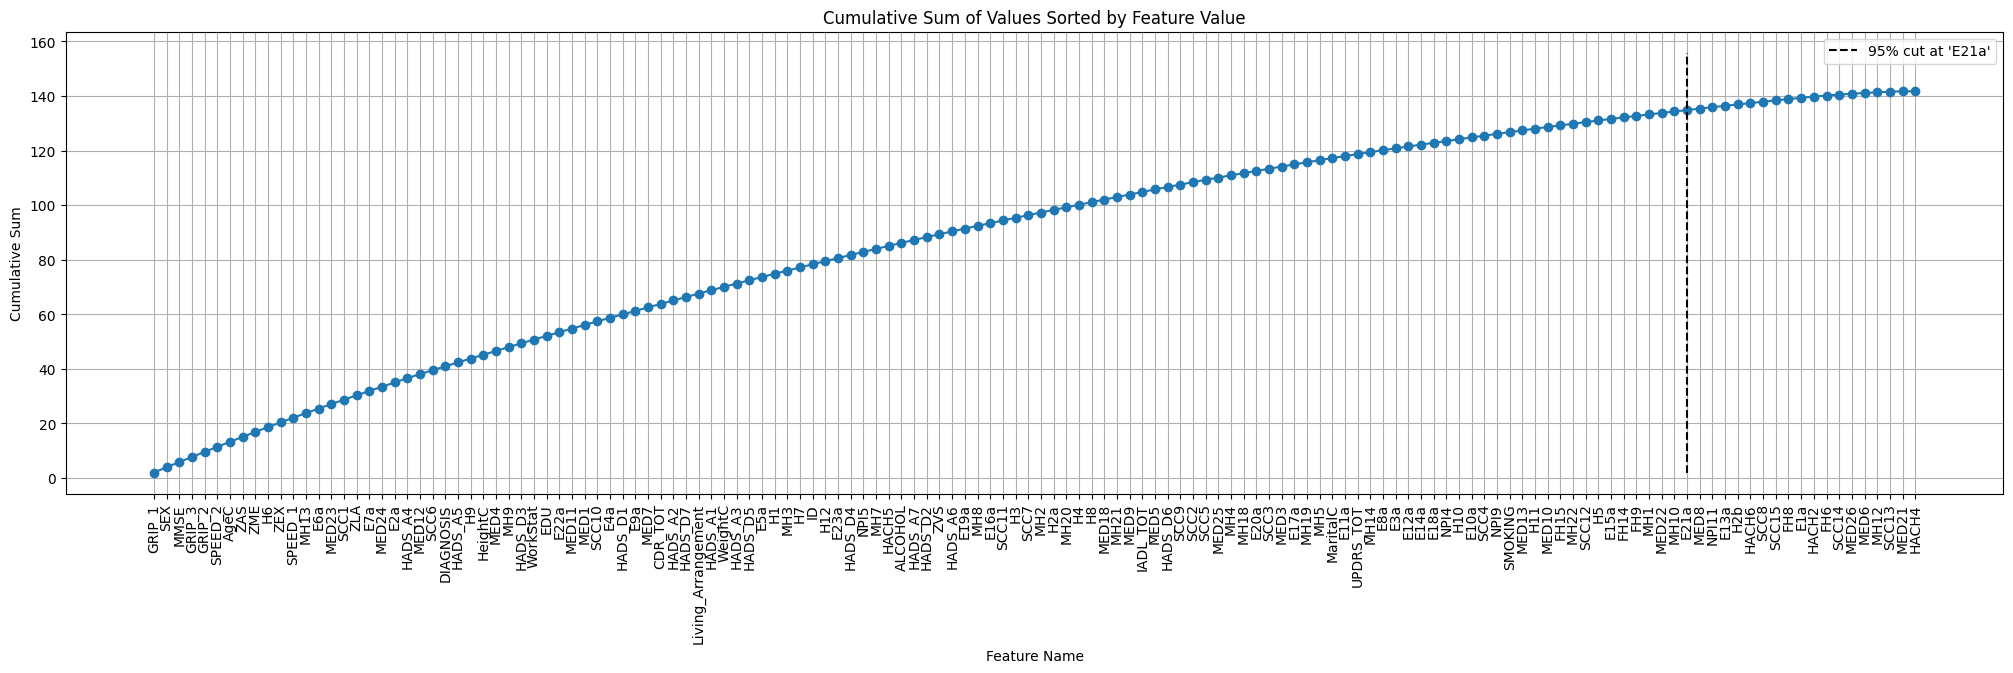

In [79]:
# Print the limit feature
print(f"\nLimit feature (where 95% cumulative sum is reached or fallback): {limit_feature}")

# Plotting
plt.figure(figsize=(25,6))
plt.plot(sorted_df_visit3['feature_name'], sorted_df_visit3['cumulative_sum'], marker='o')
plt.vlines(
    x=limit_feature,
    ymin=sorted_df_visit3['cumulative_sum'].min(),
    ymax=1.1 * sorted_df_visit3['cumulative_sum'].max(),
    label=f"95% cut at '{limit_feature}'",
    linestyles="dashed",
    color='black'
)
plt.xlabel('Feature Name')
plt.ylabel('Cumulative Sum')
plt.title('Cumulative Sum of Values Sorted by Feature Value')
plt.xticks(rotation=90)
plt.legend()
plt.grid(True)
plt.show()

In [81]:
# Remove unimportant features, in terms of mutual information and Spearman correlation
features_to_drop_visit3 = filtered_df_visit3['feature_name'].tolist()
df_visit3 = df_visit3.drop(columns=features_to_drop_visit3)

In [82]:
df_visit3 = df_visit3.drop(columns=["SCC2", "HADS_D1", "E14a", "E12a", "H4","E6a", "H9", "E7a","H1", "H8", "E8a", 
                                    "E11a","E9a","H11", "H7", "H12", "H6","SCC4", "MED11", "GRIP_2", "H3", "SPEED_2",])# Manually selected from the next step, features that had correlation >0.85

corr_matrix_visit3 = df_visit3.corr()

corr_unstacked_visit3 = corr_matrix_visit3.unstack()

# Convert to a DataFrame and reset index
corr_df_visit3 = pd.DataFrame(corr_unstacked_visit3, columns=['correlation']).reset_index()

# Rename the columns for better understanding
corr_df_visit3.columns = ['Variable_1', 'Variable_2', 'correlation']

# Remove self-correlations
corr_df_visit3 = corr_df_visit3[corr_df_visit3['Variable_1'] != corr_df_visit3['Variable_2']]

# Drop duplicate pairs
corr_df_visit3['pair'] = corr_df_visit3.apply(lambda row: tuple(sorted([row['Variable_1'], row['Variable_2']])), axis=1)
corr_df_visit3 = corr_df_visit3.drop_duplicates(subset=['pair'])

# Drop the 'pair' column as it's no longer needed
corr_df_visit3 = corr_df_visit3.drop(columns=['pair'])

# Sort by correlation value in descending order
corr_df = corr_df_visit3.sort_values(by='correlation', ascending=False)

In [83]:
corr_df_visit3[corr_df_visit3['correlation'] > 0.85] 

,Variable_1,Variable_2,correlation


## Final feature removal

In [87]:
# Earlier feature selection steps have identified the following features as highly correlated
correlated_features_visit1 = ["MH2", "MH8", "HACH5"] 
correlated_features_visit2 = ["GRIP_2", "GRIP_3", "E1a", "E23a", "H7", "E8a", "MH2", "SCC4"] 
correlated_features_visit3 = ["SCC2", "HADS_D1", "E14a", "E12a", "H4","E6a", "H9", "E7a","H1", "H8", "E8a", "E11a","E9a","H11", "H7", "H12", "H6","SCC4", "MED11", "GRIP_2", "H3", "SPEED_2",]

# Combine all features to drop
correlated_features_model_123_visit = list(set(correlated_features_visit1 + correlated_features_visit2 + correlated_features_visit3))
unique_features_to_drop_model_123_visit = list(set(features_to_drop_model_1_visit + features_to_drop_visit2 + constant_columns_model_1_visit + constant_columns_visit2 + correlated_features_model_123_visit))

# Exclude VisitNuA
unique_features_to_drop_model_123_visit.remove("VisitNuA")

train_df_model_123_visit = train_df_model_123_visit.drop(labels=unique_features_to_drop_model_123_visit, axis=1)
test_df_model_123_visit = test_df_model_123_visit.drop(labels=unique_features_to_drop_model_123_visit, axis=1)

## Train and test split

In [88]:
# Function to append visit information to IDs
def append_visit_suffix(ids, visit_columns, df):
    # Identify the visit column with value 1
    visit_suffix = df[visit_columns].idxmax(axis=1).str.split('_').str[-1]
    # Handle cases where no visit column has a value of 1 (assume it's VisitNuA_1)
    visit_suffix[df[visit_columns].sum(axis=1) == 0] = '1'
    # Append the visit suffix to the ID
    return ids + '_visit' + visit_suffix

# Define visit columns (excluding VisitNuA_1)
visit_columns_model_123_visit = ['VisitNuA_2', 'VisitNuA_3']

# Apply the function to train and test datasets
train_ids_model_123_visit = append_visit_suffix(train_df_model_123_visit['ID'].astype(str), visit_columns_model_123_visit, train_df_model_123_visit)
test_ids_model_123_visit = append_visit_suffix(test_df_model_123_visit['ID'].astype(str), visit_columns_model_123_visit, test_df_model_123_visit)

# Define features and target variable for model training (excluding 'ID')
X_train_model_123_visit = train_df_model_123_visit.drop(columns=['DIAGNOSIS', 'ID'])
y_train_model_123_visit = train_df_model_123_visit['DIAGNOSIS']

X_test_model_123_visit = test_df_model_123_visit.drop(columns=['DIAGNOSIS', 'ID'])
y_test_model_123_visit = test_df_model_123_visit['DIAGNOSIS']

## Model

  0%|          | 0/8 [00:00<?, ?trial/s, best loss=?]

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[20:52:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[20:52:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[20:52:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[20:52:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.





 12%|█▎        | 1/8 [00:00<00:03,  2.17trial/s, best loss: -0.8465995975855132]

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[20:52:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[20:52:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[20:52:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[20:52:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages

 25%|██▌       | 2/8 [00:00<00:02,  2.03trial/s, best loss: -0.860804828973843] 

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[20:52:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[20:52:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[20:52:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[20:52:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.





 38%|███▊      | 3/8 [00:01<00:01,  2.57trial/s, best loss: -0.8779074446680081]

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[20:52:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[20:52:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[20:52:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[20:52:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages

 50%|█████     | 4/8 [00:01<00:01,  2.24trial/s, best loss: -0.8779074446680081]

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[20:52:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[20:52:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[20:52:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[20:52:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.





 62%|██████▎   | 5/8 [00:02<00:01,  2.56trial/s, best loss: -0.8779074446680081]

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[20:52:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[20:52:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[20:52:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.





 75%|███████▌  | 6/8 [00:02<00:00,  2.74trial/s, best loss: -0.8779074446680081]

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[20:52:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[20:52:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[20:52:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[20:52:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages

 88%|████████▊ | 7/8 [00:03<00:00,  1.59trial/s, best loss: -0.8779074446680081]

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[20:52:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[20:52:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[20:52:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[20:52:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.





100%|██████████| 8/8 [00:04<00:00,  1.87trial/s, best loss: -0.8807243460764587]
Best hyperparameters: {'colsample_bytree': np.float64(0.8950326994698486), 'eta': np.float64(0.01355568578855607), 'max_depth': np.float64(20.0), 'min_child_weight': np.float64(8.0), 'n_estimators': np.float64(420.0), 'subsample': np.float64(0.6257147453238197)}
[0]	validation_0-logloss:0.59025
[1]	validation_0-logloss:0.58359
[2]	validation_0-logloss:0.57781
[3]	validation_0-logloss:0.57143
[4]	validation_0-logloss:0.56554
[5]	validation_0-logloss:0.56223
[6]	validation_0-logloss:0.55667
[7]	validation_0-logloss:0.55126
[8]	validation_0-logloss:0.54608
[9]	validation_0-logloss:0.54094
[10]	validation_0-logloss:0.53548
[11]	validation_0-logloss:0.53026
[12]	validation_0-logloss:0.52713
[13]	validation_0-logloss:0.52247
[14]	validation_0-logloss:0.51768
[15]	validation_0-logloss:0.51317
[16]	validation_0-logloss:0.50847
[17]	validation_0-logloss:0.50429
[18]	validation_0-logloss:0.49997
[19]	validation_0-lo

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[20:52:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[20:52:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




[72]	validation_0-logloss:0.36851
[73]	validation_0-logloss:0.36719
[74]	validation_0-logloss:0.36598
[75]	validation_0-logloss:0.36457
[76]	validation_0-logloss:0.36317
[77]	validation_0-logloss:0.36274
[78]	validation_0-logloss:0.36140
[79]	validation_0-logloss:0.36000
[80]	validation_0-logloss:0.35864
[81]	validation_0-logloss:0.35769
[82]	validation_0-logloss:0.35623
[83]	validation_0-logloss:0.35539
[84]	validation_0-logloss:0.35435
[85]	validation_0-logloss:0.35343
[86]	validation_0-logloss:0.35211
[87]	validation_0-logloss:0.35080
[88]	validation_0-logloss:0.34984
[89]	validation_0-logloss:0.34912
[90]	validation_0-logloss:0.34802
[91]	validation_0-logloss:0.34695
[92]	validation_0-logloss:0.34616
[93]	validation_0-logloss:0.34493
[94]	validation_0-logloss:0.34431
[95]	validation_0-logloss:0.34332
[96]	validation_0-logloss:0.34237
[97]	validation_0-logloss:0.34128
[98]	validation_0-logloss:0.34007
[99]	validation_0-logloss:0.33902
[100]	validation_0-logloss:0.33803
[101]	validat

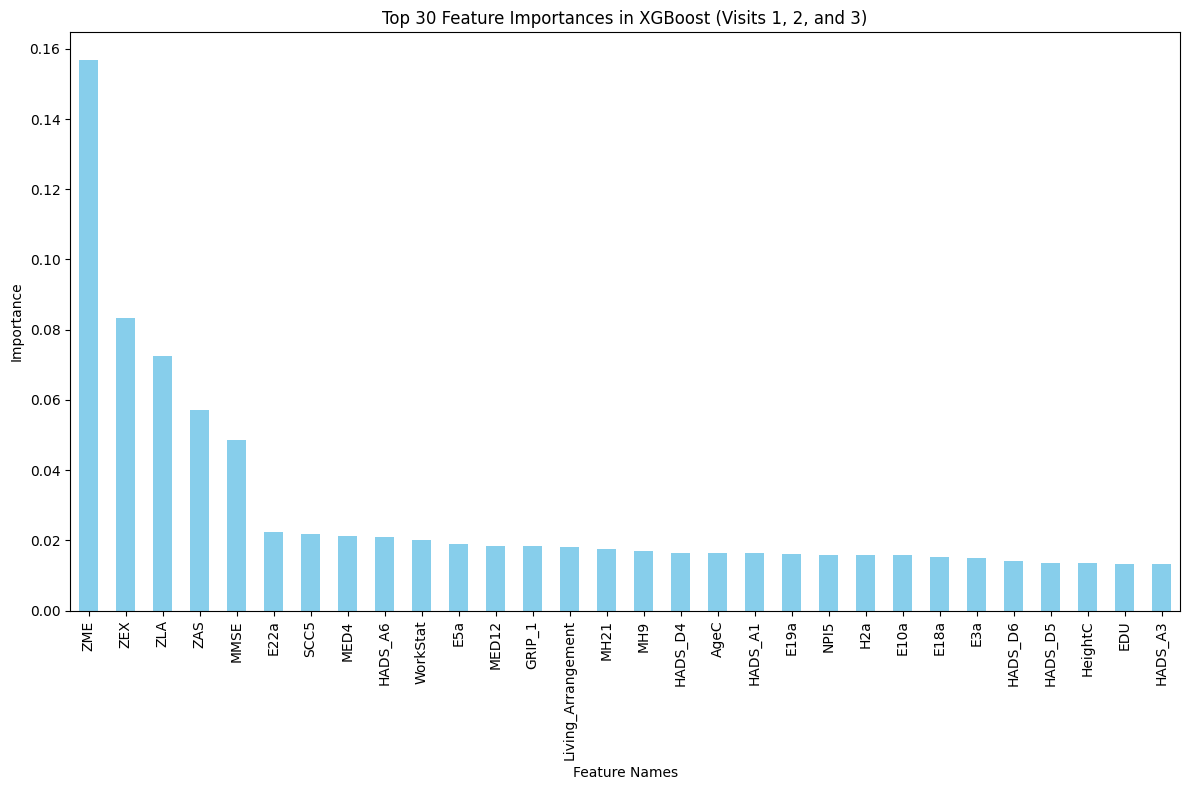

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[20:52:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[20:52:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[20:52:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[20:52:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgb

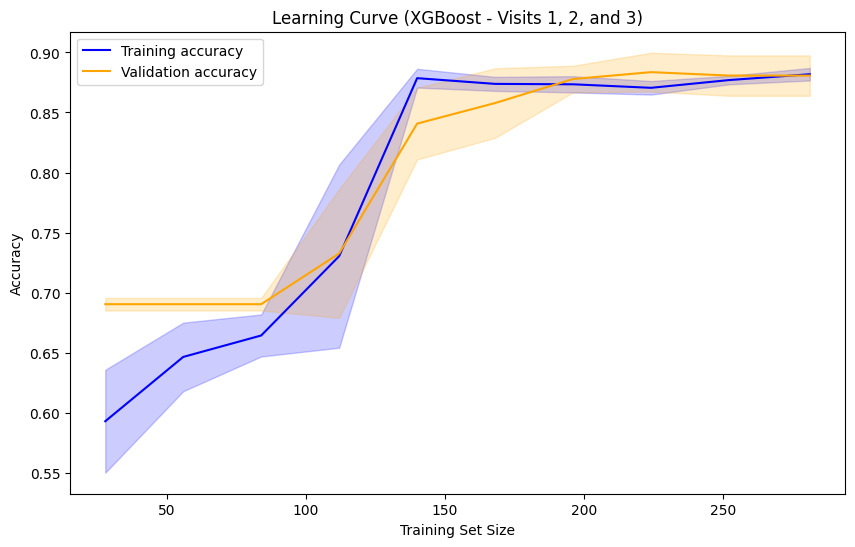

In [90]:
# Define the objective function for Hyperopt
def objective(params):
    params['max_depth'] = int(params['max_depth'])
    params['min_child_weight'] = int(params['min_child_weight'])
    params['n_estimators'] = int(params['n_estimators'])

    model = XGBClassifier(
        **params,
        use_label_encoder=False,
        random_state=random_seed,
        verbosity=1,
    )
    # Perform cross-validation
    scores = cross_val_score(model, X_train_model_123_visit, y_train_model_123_visit, cv=5, scoring='accuracy')
    return -np.mean(scores)

# Define the search space for XGBClassifier parameters
search_space = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'eta': hp.loguniform('eta', -5, 0),
    'max_depth': scope.int(hp.quniform('max_depth', 5, 50, 1)),
    'min_child_weight': scope.int(hp.quniform('min_child_weight', 1, 10, 1)),
    'subsample': hp.uniform('subsample', 0.6, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),
    'n_estimators': scope.int(hp.quniform('n_estimators', 50, 500, 10)),
}

# Run the optimization with Hyperopt
trials = Trials()
best_params_123 = fmin(fn=objective, space=search_space, algo=tpe.suggest, max_evals=8, trials=trials, rstate=np.random.default_rng(random_seed))

print(f"Best hyperparameters: {best_params_123}")

# Convert the best params for training
final_params_123 = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'eta': best_params_123['eta'],
    'max_depth': int(best_params_123['max_depth']),
    'min_child_weight': int(best_params_123['min_child_weight']),
    'subsample': best_params_123['subsample'],
    'colsample_bytree': best_params_123['colsample_bytree'],
    'n_estimators': int(best_params_123['n_estimators']),
    'random_state': random_seed,
    'use_label_encoder': False,
    'early_stopping_rounds': 10,
}

# Train the model
xgb_model_visits_123 = XGBClassifier(**final_params_123)
xgb_model_visits_123.fit(X_train_model_123_visit, y_train_model_123_visit, eval_set=[(X_test_model_123_visit, y_test_model_123_visit)], verbose=True)

# Make predictions
y_pred_prob_visits_123 = xgb_model_visits_123.predict_proba(X_test_model_123_visit)[:, 1]
y_pred_visits_123 = (y_pred_prob_visits_123 > 0.5).astype(int)

# Evaluate the model
accuracy_visits_123 = accuracy_score(y_test_model_123_visit, y_pred_visits_123)
conf_matrix_visits_123 = confusion_matrix(y_test_model_123_visit, y_pred_visits_123)
class_report_visits_123 = classification_report(y_test_model_123_visit, y_pred_visits_123)
mcc_visits_123 = matthews_corrcoef(y_test_model_123_visit, y_pred_visits_123)

print(f"Test Set Accuracy: {accuracy_visits_123}")
print("Test Set Confusion Matrix:")
print(conf_matrix_visits_123)
print("Test Set Classification Report:")
print(class_report_visits_123)
print(f"Test Set MCC: {mcc_visits_123}")

# Feature importance analysis
feature_importances_visits_123 = xgb_model_visits_123.feature_importances_
feature_names_visits_123 = X_train_model_123_visit.columns if hasattr(X_train_model_123_visit, 'columns') else [f"Feature {i}" for i in range(X_train_model_123_visit.shape[1])]
feat_importances_visits_123 = pd.Series(feature_importances_visits_123, index=feature_names_visits_123)
feat_importances_visits_123 = feat_importances_visits_123.sort_values(ascending=False)

# Plot top 30 feature importances
plt.figure(figsize=(12, 8))
feat_importances_visits_123[:30].plot(kind='bar', color='skyblue')
plt.title('Top 30 Feature Importances in XGBoost (Visits 1, 2, and 3)')
plt.ylabel('Importance')
plt.xlabel('Feature Names')
plt.tight_layout()
plt.show()

# Remove `early_stopping_rounds` for the learning curve
params_for_learning_curve_visits_123 = {key: value for key, value in final_params_123.items() if key != 'early_stopping_rounds'}

# Generate the learning curve
train_sizes_visits_123, train_scores_visits_123, val_scores_visits_123 = learning_curve(
    XGBClassifier(**params_for_learning_curve_visits_123),
    X_train_model_123_visit,
    y_train_model_123_visit,
    cv=5,
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10),
    random_state=random_seed
)

# Calculate means and standard deviations
train_scores_mean_visits_123 = np.mean(train_scores_visits_123, axis=1)
train_scores_std_visits_123 = np.std(train_scores_visits_123, axis=1)
val_scores_mean_visits_123 = np.mean(val_scores_visits_123, axis=1)
val_scores_std_visits_123 = np.std(val_scores_visits_123, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes_visits_123, train_scores_mean_visits_123, label='Training accuracy', color='blue')
plt.fill_between(train_sizes_visits_123, train_scores_mean_visits_123 - train_scores_std_visits_123,
                 train_scores_mean_visits_123 + train_scores_std_visits_123, alpha=0.2, color='blue')
plt.plot(train_sizes_visits_123, val_scores_mean_visits_123, label='Validation accuracy', color='orange')
plt.fill_between(train_sizes_visits_123, val_scores_mean_visits_123 - val_scores_std_visits_123,
                 val_scores_mean_visits_123 + val_scores_std_visits_123, alpha=0.2, color='orange')
plt.title('Learning Curve (XGBoost - Visits 1, 2, and 3)')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Individual Predictions

In [92]:
# Create a DataFrame to store the test IDs, true labels, and predictions
predictions_df_model_123_visit = pd.DataFrame({
    'ID': test_ids_model_123_visit,           # Use the test IDs from earlier
    'True_Label': y_test_model_123_visit,     # True labels from the test set
    'Predicted_Label': y_pred_visits_123 # Predicted labels from the model
})

predictions_df_model_123_visit

# Analyze mismatches (where true label != predicted label)
mismatches_model_123_visit = predictions_df_model_123_visit[predictions_df_model_123_visit['True_Label'] != predictions_df_model_123_visit['Predicted_Label']]
print("Mismatches:")
print(mismatches_model_123_visit)


Mismatches:
             ID  True_Label  Predicted_Label
1   6050_visit1           1                0
22  6987_visit1           0                1
25  7039_visit1           1                0
32  7323_visit1           0                1
38  8059_visit1           1                0
41  8212_visit1           1                0
65  6987_visit2           0                1
71  5111_visit3           0                1
83  6987_visit3           0                1


In [93]:
# Save predictions for ensemble
predictions_df_model_123_visit.to_csv('../data/predictions_model_visit123.csv', index=False)

## Individual Explainer Dashboard

In [94]:
# Create an explainer object
explainer_model_123_visit = ClassifierExplainer(xgb_model_visits_123, X_test_model_123_visit, y_test_model_123_visit,
                                labels = ["NC", "MCI"],
                                target = "DIAGNOSIS",
                                index_name = "Participant",
                                idxs = test_ids_model_123_visit,
                                )

# Initialize the dashboard
dashboard_model_123_visit = ExplainerDashboard(explainer_model_123_visit, 
                        title="Model 3 (XGBoost) - 1st, 2nd and 3rd Visit", # defaults to "Model Explainer"
                        # importances=True,
                        # model_summary=True,
                        # hide_globalcutoff=True, hide_precision=True, hide_classification=True, hide_cumprecision=True,
                        # contributions=True,
                        # hide_pdp=True, 
                        # whatif=True,
                        # hide_whatifpdp=True,
                        # shap_dependence=True,
                        # shap_interaction=False,
                        # decision_trees=False,
                        # hide_poweredby=True,
                        # hide_depth=True,
                        # hide_sort=True,
                        # permutation_importance=True,
                        )

# Run the dashboard (this will start a web server)
# dashboard_model_123_visit.run(port=8055)

Detected XGBClassifier model: Changing class type to XGBClassifierExplainer...
Note: model_output=='probability'. For XGBClassifier shap values normally get calculated against X_background, but paramater X_background=None, so using X instead
Generating self.shap_explainer = shap.TreeExplainer(model, X, model_output='probability', feature_perturbation='interventional')...
Note: Shap interaction values will not be available. If shap values in probability space are not necessary you can pass model_output='logodds' to get shap values in logodds without the need for a background dataset and also working shap interaction values...
Building ExplainerDashboard..
Detected notebook environment, consider setting mode='external', mode='inline' or mode='jupyterlab' to keep the notebook interactive while the dashboard is running...
For this type of model and model_output interactions don't work, so setting shap_interaction=False...
Generating layout...
Calculating shap values...
Calculating predicti

# ExplainerHub

In [95]:
# Create a hub
hub = ExplainerHub(
    [dashboard_model_1_visit, dashboard_model_12_visit, dashboard_model_123_visit],
    title="Dementia Diagnosis Hub",
    description="A hub that contains the individual models of the Voting-Based Hybrid Model."
)

# Run the hub
hub.run(port=8041)

Using random SECRET_KEY: d01fa014-62de-4cac-92bb-e633cbc522a5, please set it on your app.config["SECRET_KEY"]


Reminder, you can set ExplainerDashboard .name and .description in order to control the url path of the dashboard. Now defaulting to name=dashboard1 and default description...
Building ExplainerDashboard..
Detected notebook environment, consider setting mode='external', mode='inline' or mode='jupyterlab' to keep the notebook interactive while the dashboard is running...
For this type of model and model_output interactions don't work, so setting shap_interaction=False...
Generating layout...
Calculating dependencies...
Reminder: you can store the explainer (including calculated dependencies) with explainer.dump('explainer.joblib') and reload with e.g. ClassifierExplainer.from_file('explainer.joblib')
Registering callbacks...
Reminder, you can set ExplainerDashboard .name and .description in order to control the url path of the dashboard. Now defaulting to name=dashboard2 and default description...
Building ExplainerDashboard..
Detected notebook environment, consider setting mode='extern

 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:8041
 * Running on http://137.56.43.100:8041
Press CTRL+C to quit
137.56.43.100 - - [19/Jan/2025 20:53:51] "GET / HTTP/1.1" 200 -
137.56.43.100 - - [19/Jan/2025 20:53:51] "GET /static/bootstrap.min.css HTTP/1.1" 304 -
137.56.43.100 - - [19/Jan/2025 20:53:51] "GET /f"/static/jquery-3.5.1.slim.min.js" HTTP/1.1" 404 -
137.56.43.100 - - [19/Jan/2025 20:53:51] "GET /f"/static/bootstrap.min.js" HTTP/1.1" 404 -
137.56.43.100 - - [19/Jan/2025 20:53:51] "GET /index/ HTTP/1.1" 200 -
137.56.43.100 - - [19/Jan/2025 20:53:51] "GET /index/assets/bootstrap.min.css?m=1729586741.3383403 HTTP/1.1" 304 -
137.56.43.100 - - [19/Jan/2025 20:53:51] "GET /index/_dash-layout HTTP/1.1" 200 -
137.56.43.100 - - [19/Jan/2025 20:53:51] "GET /index/_dash-dependencies HTTP/1.1" 200 -
137.56.43.100 - - [19/Jan/2025 20:53:56] "GET /dashboards/dashboard1 HTTP/1.1" 308 -
137.56.43.100 - - [19/Jan/2025 20:53:56] "GET /dashboards/dashboard1/ HTTP/1.1" 200

Empty DataFrame
Columns: [col, contribution, value]
Index: []
Empty DataFrame
Columns: [col, contribution, value]
Index: []


137.56.43.100 - - [19/Jan/2025 22:31:49] "POST /dashboards/dashboard1/_dash-update-component HTTP/1.1" 200 -
137.56.43.100 - - [19/Jan/2025 22:38:21] "POST /dashboards/dashboard1/_dash-update-component HTTP/1.1" 200 -


                    col  contribution       value
0                   SEX           0.0    2.000000
1                   EDU           0.0   16.000000
2                  AgeC           0.0   69.000000
3              ΜaritalC           0.0    1.000000
4    Living_Arrangement           0.0    1.000000
5              WorkStat           0.0    2.000000
6                   MH3           0.0    0.000000
7                   MH4           0.0    0.000000
8                   MH6           0.0    0.000000
9                   MH7           0.0    0.000000
10                  MH8           0.0    0.000000
11                  MH9           0.0    1.000000
12                 MH10           0.0    0.000000
13                 MH16           0.0    0.000000
14                 MH19           0.0    0.000000
15                 MH20           0.0    0.000000
16                 MH21           0.0    0.000000
17                 MED1           0.0    0.000000
18                 MED2           0.0    0.000000


137.56.43.100 - - [19/Jan/2025 22:41:27] "GET / HTTP/1.1" 200 -
137.56.43.100 - - [19/Jan/2025 22:41:27] "GET /f"/static/jquery-3.5.1.slim.min.js" HTTP/1.1" 404 -
137.56.43.100 - - [19/Jan/2025 22:41:27] "GET /f"/static/bootstrap.min.js" HTTP/1.1" 404 -
137.56.43.100 - - [19/Jan/2025 22:41:27] "GET /static/bootstrap.min.css HTTP/1.1" 304 -
137.56.43.100 - - [19/Jan/2025 22:41:27] "GET /index/ HTTP/1.1" 200 -
137.56.43.100 - - [19/Jan/2025 22:41:27] "GET /index/assets/bootstrap.min.css?m=1729586741.3383403 HTTP/1.1" 304 -
137.56.43.100 - - [19/Jan/2025 22:41:27] "GET /index/_dash-layout HTTP/1.1" 200 -
137.56.43.100 - - [19/Jan/2025 22:41:27] "GET /index/_dash-dependencies HTTP/1.1" 200 -
137.56.43.100 - - [19/Jan/2025 22:41:29] "GET /dashboards/dashboard1 HTTP/1.1" 308 -
137.56.43.100 - - [19/Jan/2025 22:41:29] "GET /dashboards/dashboard1/ HTTP/1.1" 200 -
137.56.43.100 - - [19/Jan/2025 22:41:29] "GET /dashboards/dashboard1/assets/bootstrap.min.css?m=1729586741.3383403 HTTP/1.1" 304 -
1